# Census Income Project

# Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). 

Objective: The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight):

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [134]:
#Importing the necessary Libraries

# linear algebra
import numpy as np 

import warnings
warnings.simplefilter("ignore")

# data processing
import pandas as pd
from pandas_profiling import ProfileReport

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
import six
import sys
sys.modules['sklearn.externals.six']=six
import mlrose
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier.rocauc import roc_auc

from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler,power_transform
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.model_selection import StratifiedKFold
import scikitplot as skplt
from sklearn import metrics

from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import pickle
import joblib

# Loading the Dataset

In [135]:
df=pd.read_csv('census.csv')

In [136]:
df

Age          Workclass  Fnlwgt    Education  Education_num  \
0       50   Self-emp-not-inc   83311    Bachelors             13   
1       38            Private  215646      HS-grad              9   
2       53            Private  234721         11th              7   
3       28            Private  338409    Bachelors             13   
4       37            Private  284582      Masters             14   
...    ...                ...     ...          ...            ...   
32555   27            Private  257302   Assoc-acdm             12   
32556   40            Private  154374      HS-grad              9   
32557   58            Private  151910      HS-grad              9   
32558   22            Private  201490      HS-grad              9   
32559   52       Self-emp-inc  287927      HS-grad              9   

            Marital_status          Occupation    Relationship    Race  \
0       Married-civ-spouse     Exec-managerial         Husband   White   
1                 Divorced   Handlers-cleaners   Not-in-family   White   
2       Married-civ-spouse   Handlers-cleaners         Husband   Black   
3       Married-civ-spouse      Prof-specialty            Wife   Black   
4       Married-civ-spouse     Exec-managerial            Wife   White   
...                    ...                 ...             ...     ...   
32555   Married-civ-spouse        Tech-support            Wife   White   
32556   Married-civ-spouse   Machine-op-inspct         Husband   White   
32557              Widowed        Adm-clerical       Unmarried   White   
32558        Never-married        Adm-clerical       Own-child   White   
32559   Married-civ-spouse     Exec-managerial            Wife   White   

           Sex  Capital_gain  Capital_loss  Hours_per_week  Native_country  \
0         Male             0             0              13   United-States   
1         Male             0             0              40   United-States   
2         Male             0             0              40   United-States   
3       Female             0             0              40            Cuba   
4       Female             0             0              40   United-States   
...        ...           ...           ...             ...             ...   
32555   Female             0             0              38   United-States   
32556     Male             0             0              40   United-States   
32557   Female             0             0              40   United-States   
32558     Male             0             0              20   United-States   
32559   Female         15024             0              40   United-States   

       Income  
0       <=50K  
1       <=50K  
2       <=50K  
3       <=50K  
4       <=50K  
...       ...  
32555   <=50K  
32556    >50K  
32557   <=50K  
32558   <=50K  
32559    >50K  

[32560 rows x 15 columns]

Remarks: The dataset comprises of numerical data columns and categorical data columns. Since the problem statement says that we are suppose to predict the "Income" column which has 2 class namely "<=50K" and ">50K" so it makes this to be a Classification problem.

In [137]:
#checking the dimension of the dataset
df.shape

(32560, 15)

Remarks: The dataset consists of 32560 rows and 15 columns.

# Data Exploration/Analysis

In [138]:
#checking the first 5 entries of the dataset
df.head()

Age          Workclass  Fnlwgt   Education  Education_num  \
0   50   Self-emp-not-inc   83311   Bachelors             13   
1   38            Private  215646     HS-grad              9   
2   53            Private  234721        11th              7   
3   28            Private  338409   Bachelors             13   
4   37            Private  284582     Masters             14   

        Marital_status          Occupation    Relationship    Race      Sex  \
0   Married-civ-spouse     Exec-managerial         Husband   White     Male   
1             Divorced   Handlers-cleaners   Not-in-family   White     Male   
2   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
3   Married-civ-spouse      Prof-specialty            Wife   Black   Female   
4   Married-civ-spouse     Exec-managerial            Wife   White   Female   

   Capital_gain  Capital_loss  Hours_per_week  Native_country  Income  
0             0             0              13   United-States   <=50K  
1             0             0              40   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40            Cuba   <=50K  
4             0             0              40   United-States   <=50K

In [139]:
#checking the last 5 entries of the dataset
df.tail()

Age      Workclass  Fnlwgt    Education  Education_num  \
32555   27        Private  257302   Assoc-acdm             12   
32556   40        Private  154374      HS-grad              9   
32557   58        Private  151910      HS-grad              9   
32558   22        Private  201490      HS-grad              9   
32559   52   Self-emp-inc  287927      HS-grad              9   

            Marital_status          Occupation Relationship    Race      Sex  \
32555   Married-civ-spouse        Tech-support         Wife   White   Female   
32556   Married-civ-spouse   Machine-op-inspct      Husband   White     Male   
32557              Widowed        Adm-clerical    Unmarried   White   Female   
32558        Never-married        Adm-clerical    Own-child   White     Male   
32559   Married-civ-spouse     Exec-managerial         Wife   White   Female   

       Capital_gain  Capital_loss  Hours_per_week  Native_country  Income  
32555             0             0              38   United-States   <=50K  
32556             0             0              40   United-States    >50K  
32557             0             0              40   United-States   <=50K  
32558             0             0              20   United-States   <=50K  
32559         15024             0              40   United-States    >50K

Remarks:

In [141]:
#checking column names
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [142]:
#checking the datatype information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Remarks: As we can see in the above cell, there are 6 columns with integer datatype and 9 columns that have object datatype.

In [143]:
#checking for null values
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

Remarks: There are no missing values in the dataset.

In [144]:
#checking unique values
df.nunique()

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

Remarks: In the above cell, we can see all the unique data present in each column of our dataset.

# Statistical Analysis

In [145]:
df.describe().T

count           mean            std      min       25%  \
Age             32560.0      38.581634      13.640642     17.0      28.0   
Fnlwgt          32560.0  189781.814373  105549.764924  12285.0  117831.5   
Education_num   32560.0      10.080590       2.572709      1.0       9.0   
Capital_gain    32560.0    1077.615172    7385.402999      0.0       0.0   
Capital_loss    32560.0      87.306511     402.966116      0.0       0.0   
Hours_per_week  32560.0      40.437469      12.347618      1.0      40.0   

                     50%       75%        max  
Age                 37.0      48.0       90.0  
Fnlwgt          178363.0  237054.5  1484705.0  
Education_num       10.0      12.0       16.0  
Capital_gain         0.0       0.0    99999.0  
Capital_loss         0.0       0.0     4356.0  
Hours_per_week      40.0      45.0       99.0

Remarks:

We can see all the columns are having count 32560 which indicates it doesn't contain any missing values.

Mean is greater than median in Capital_gain and capital_loss which indicates that data is right skewed.

Standard Deviation is higher Fnlwgt and capital_gain which indicates data is heavily spreaded.

Large difference between 75th percentile and max is present in Fnlwgt, capital_gain and capital_loss which indicates outliers may be there.

# Exploratory Data Analysis(EDA)

In [146]:
{column:len(df[column].unique()) for column in df.select_dtypes('object').columns}

{'Workclass': 9,
 'Education': 16,
 'Marital_status': 7,
 'Occupation': 15,
 'Relationship': 6,
 'Race': 5,
 'Sex': 2,
 'Native_country': 42,
 'Income': 2}

Remarks: In the above cell,we can see every object column and the number of unique values they have. If only one column was having all the unique values then we might have to drop that column but that is not the case here. The column that contains the maximun unique is 'Native_country'.

In [147]:
#selecting the object columns
df.select_dtypes('object')

Workclass    Education       Marital_status  \
0       Self-emp-not-inc    Bachelors   Married-civ-spouse   
1                Private      HS-grad             Divorced   
2                Private         11th   Married-civ-spouse   
3                Private    Bachelors   Married-civ-spouse   
4                Private      Masters   Married-civ-spouse   
...                  ...          ...                  ...   
32555            Private   Assoc-acdm   Married-civ-spouse   
32556            Private      HS-grad   Married-civ-spouse   
32557            Private      HS-grad              Widowed   
32558            Private      HS-grad        Never-married   
32559       Self-emp-inc      HS-grad   Married-civ-spouse   

               Occupation    Relationship    Race      Sex  Native_country  \
0         Exec-managerial         Husband   White     Male   United-States   
1       Handlers-cleaners   Not-in-family   White     Male   United-States   
2       Handlers-cleaners         Husband   Black     Male   United-States   
3          Prof-specialty            Wife   Black   Female            Cuba   
4         Exec-managerial            Wife   White   Female   United-States   
...                   ...             ...     ...      ...             ...   
32555        Tech-support            Wife   White   Female   United-States   
32556   Machine-op-inspct         Husband   White     Male   United-States   
32557        Adm-clerical       Unmarried   White   Female   United-States   
32558        Adm-clerical       Own-child   White     Male   United-States   
32559     Exec-managerial            Wife   White   Female   United-States   

       Income  
0       <=50K  
1       <=50K  
2       <=50K  
3       <=50K  
4       <=50K  
...       ...  
32555   <=50K  
32556    >50K  
32557   <=50K  
32558   <=50K  
32559    >50K  

[32560 rows x 9 columns]

# Univariate Analysis:

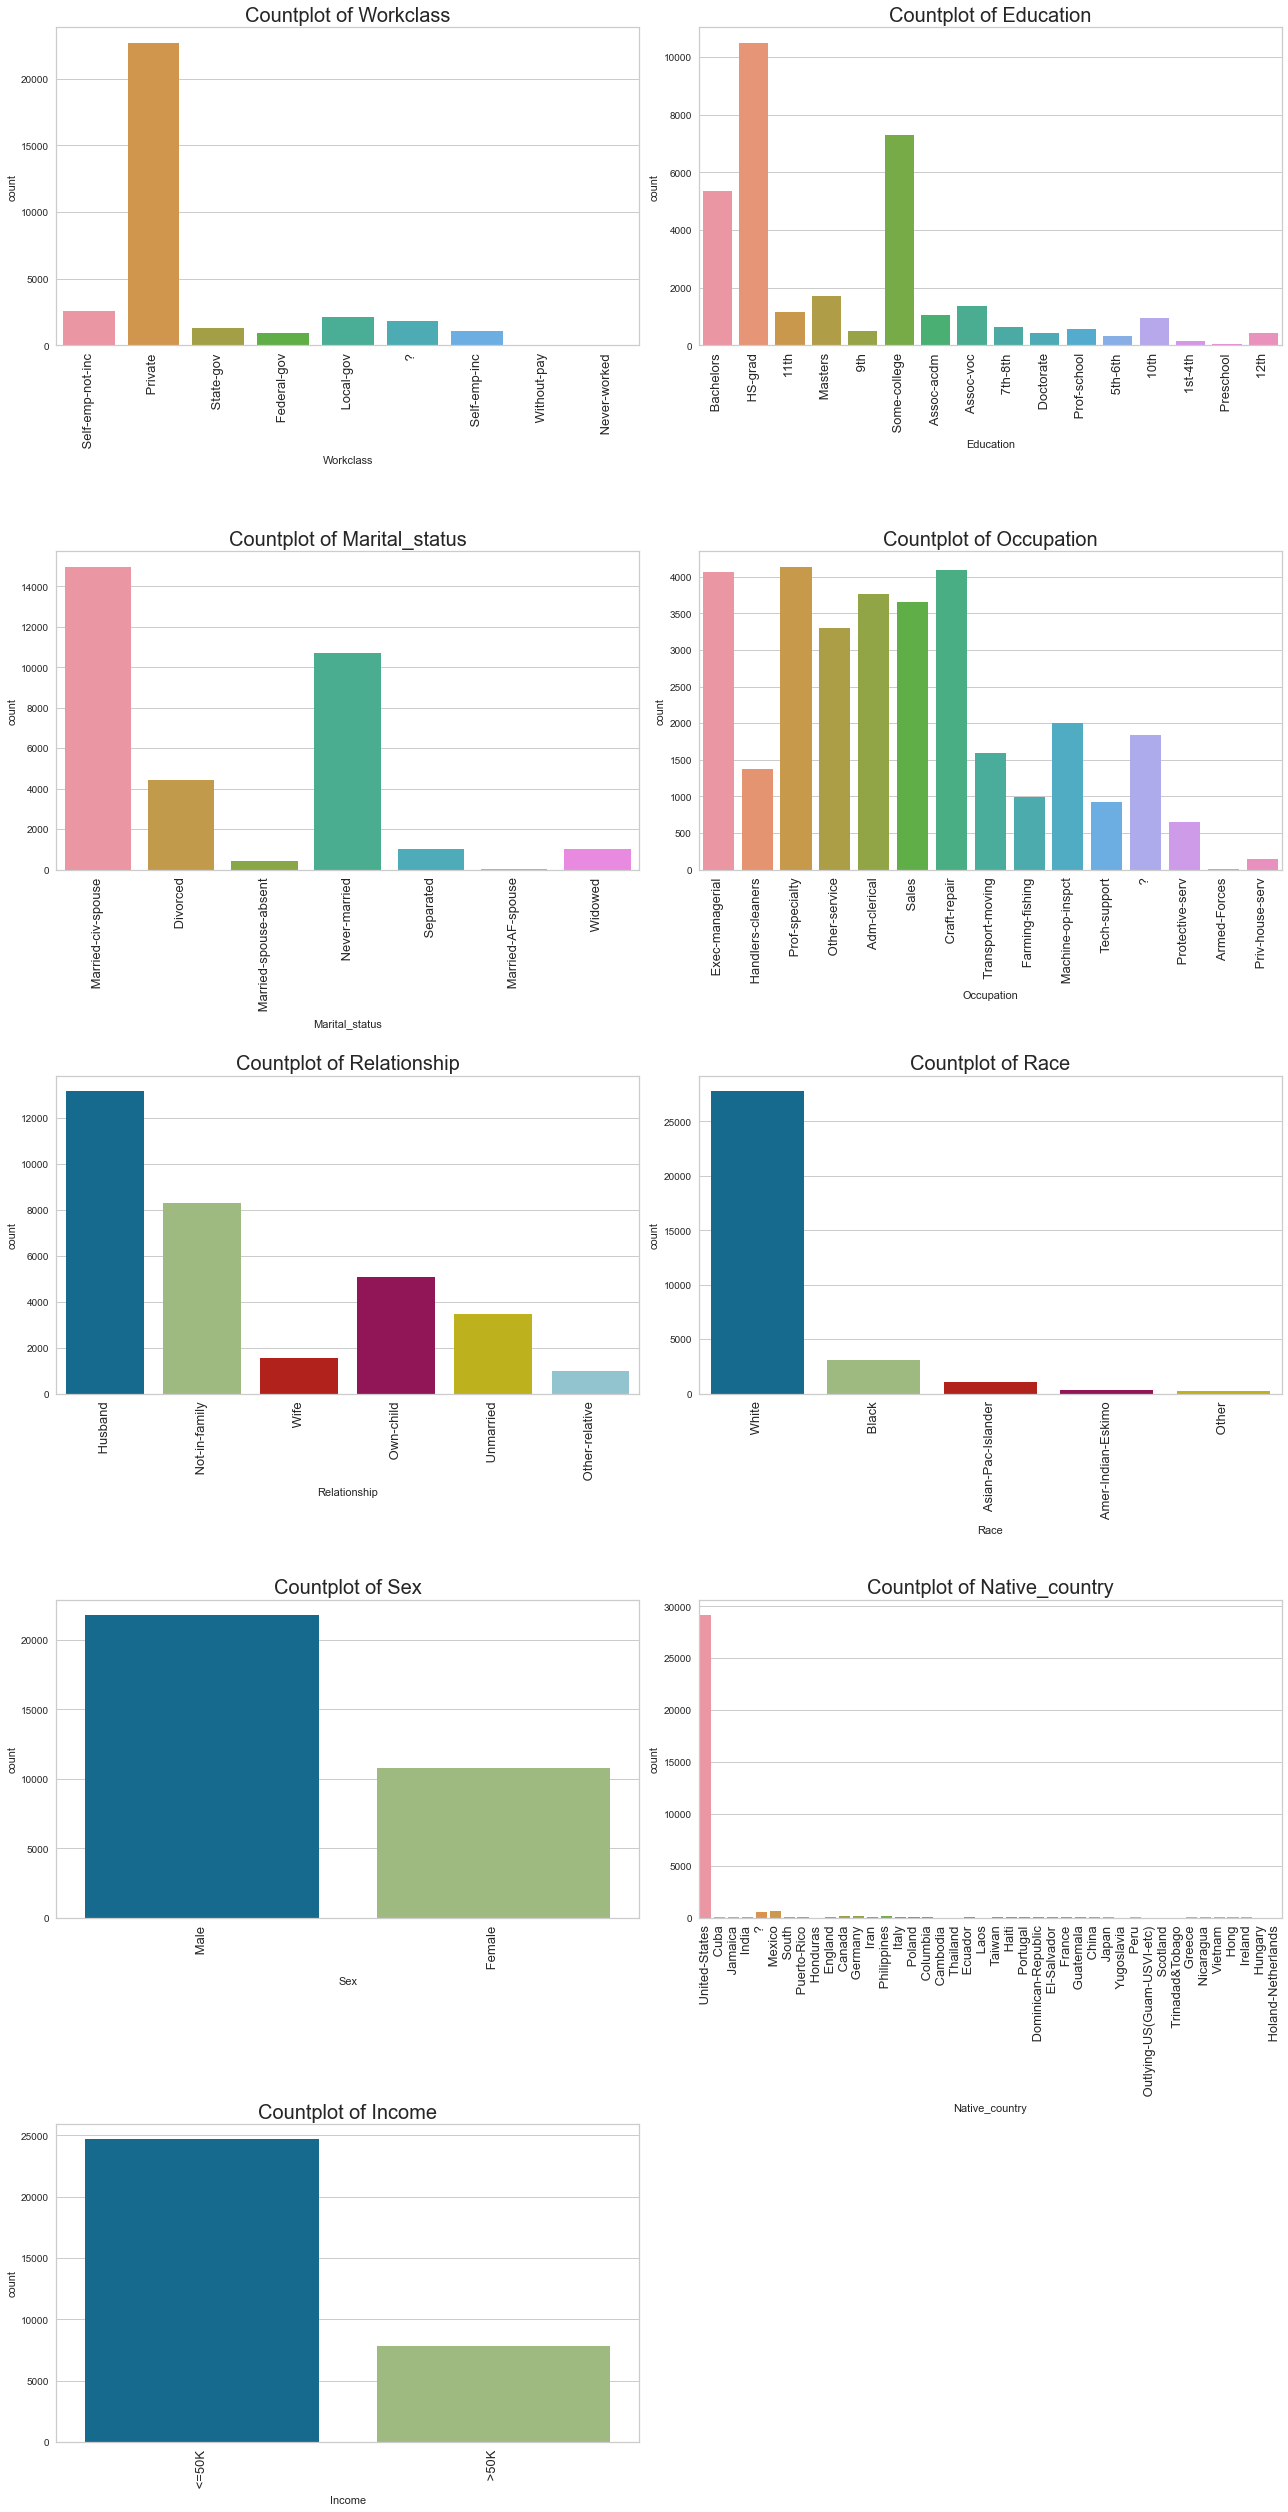

In [148]:
col=['Workclass','Education','Marital_status','Occupation','Relationship','Race','Sex','Native_country','Income']

#checking the countplots of all the object columns
plt.figure(figsize=(18,35))
for i in range(len(col)):
  plt.subplot(5,2,i+1)
  sns.countplot(df[col[i]])
  plt.title(f"Countplot of {col[i]}",fontsize=20)
  plt.xticks(rotation=90,fontsize=13)
  plt.tight_layout()

Observations:

1. In case of workclass, the highest number of people work for private sector.

2. In case of Education column, HS-grad has the highest count followed by some-college and Bachelors respectively.

3. In case of Marital_status, we see that the Marital Status column has married spouse and never married people on the higher edge as compared to the other values.

4. In case of Occupation, we can see that it has various categories out of which people in Armed Forces are the least and people engaged in craft-repair, executive managers and holding some professional speciality are on the higher side.

5. In case of Relationship, the values for husband is the highest and other relative has the lowest value.

6. In case of Race, it consists mostly of white people.

7. In case of sex, count of male is higher than female.

8. In case of Native country, we can see that most of the people are from US.

9.  In case od Income, we can see that there are more people having income less than 50k.

In [149]:
#selecting the numerical columns
df.select_dtypes(exclude='object')

Age  Fnlwgt  Education_num  Capital_gain  Capital_loss  Hours_per_week
0       50   83311             13             0             0              13
1       38  215646              9             0             0              40
2       53  234721              7             0             0              40
3       28  338409             13             0             0              40
4       37  284582             14             0             0              40
...    ...     ...            ...           ...           ...             ...
32555   27  257302             12             0             0              38
32556   40  154374              9             0             0              40
32557   58  151910              9             0             0              40
32558   22  201490              9             0             0              20
32559   52  287927              9         15024             0              40

[32560 rows x 6 columns]

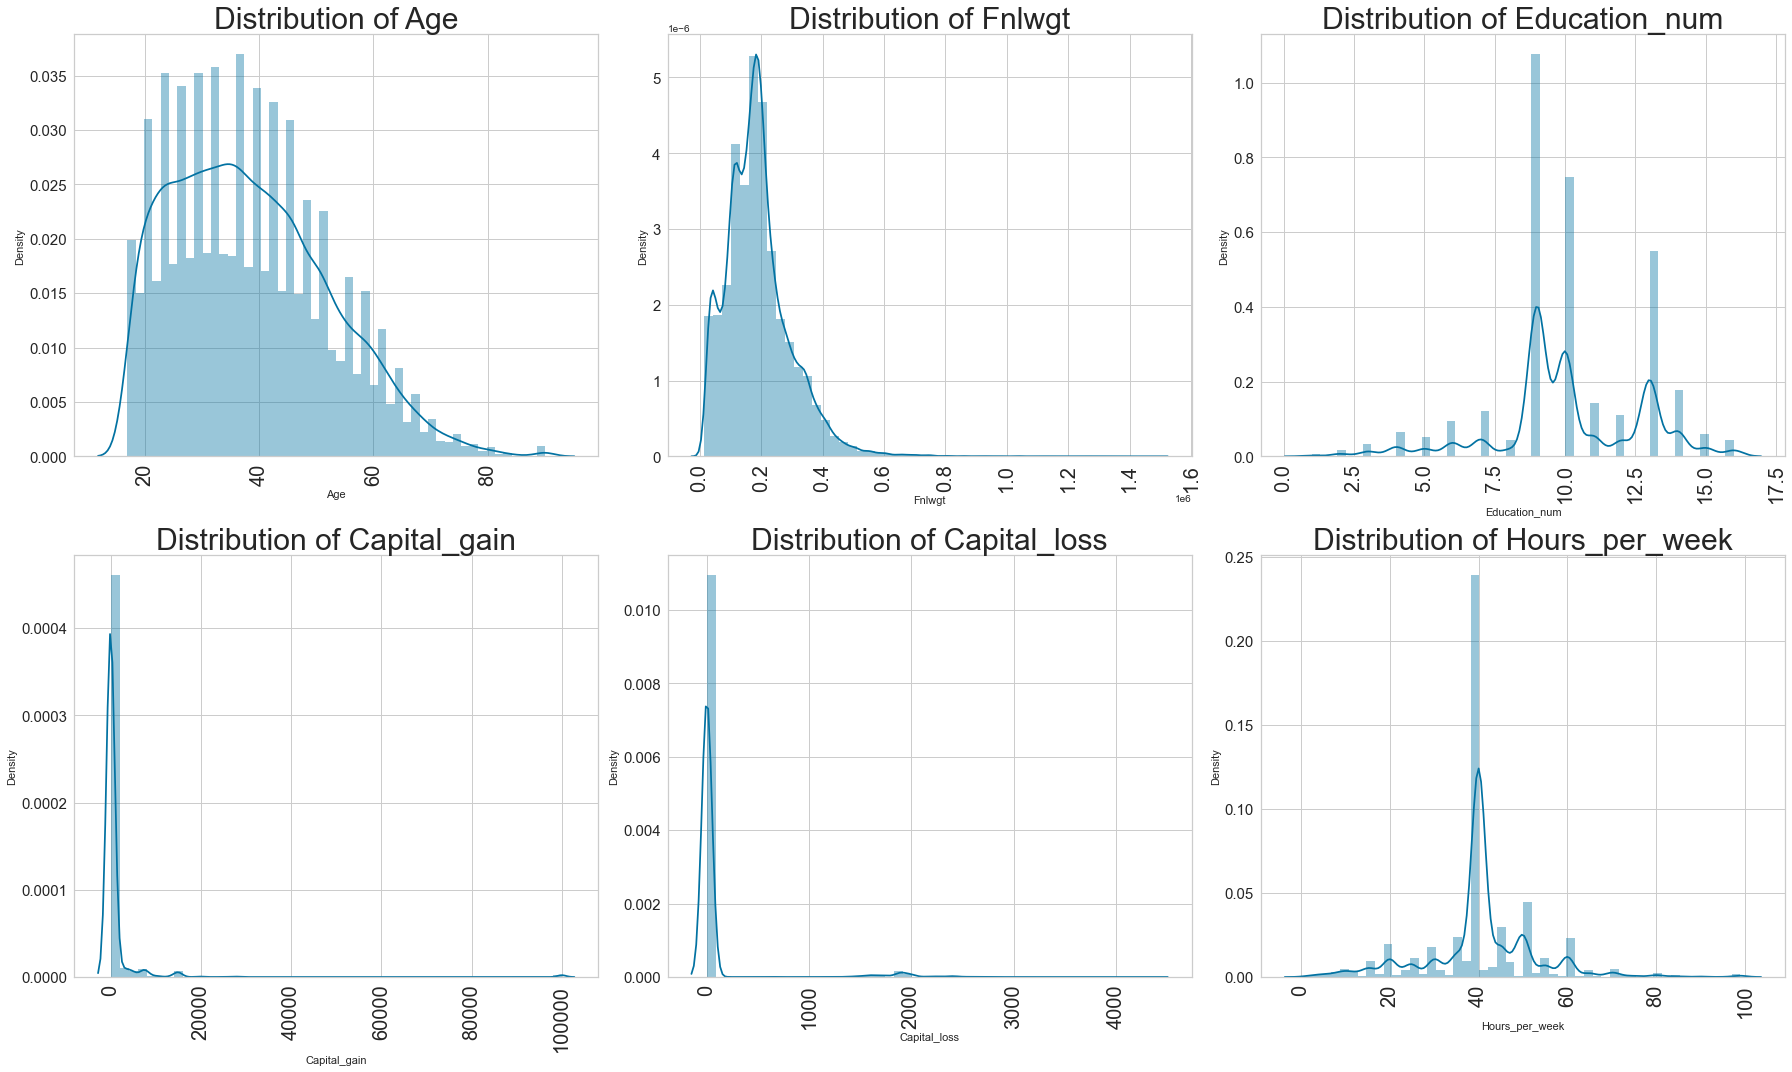

In [150]:
col1=['Age','Fnlwgt','Education_num','Capital_gain','Capital_loss','Hours_per_week']

#checking distplot for the numerical columns
plt.figure(figsize=(25,15))
for i in range(len(col1)):
  plt.subplot(2,3,i+1)
  sns.distplot(df[col1[i]])
  plt.title(f"Distribution of {col1[i]}",fontsize=30)
  plt.xticks(rotation=90,fontsize=20)
  plt.yticks(fontsize=15)
  plt.tight_layout()

Observations:

1. From the distribution plot of Fnlwgt column, we can see that the values are continuous so the distribution is right skewed.

2. The remaining distribution plot shows discrete values.

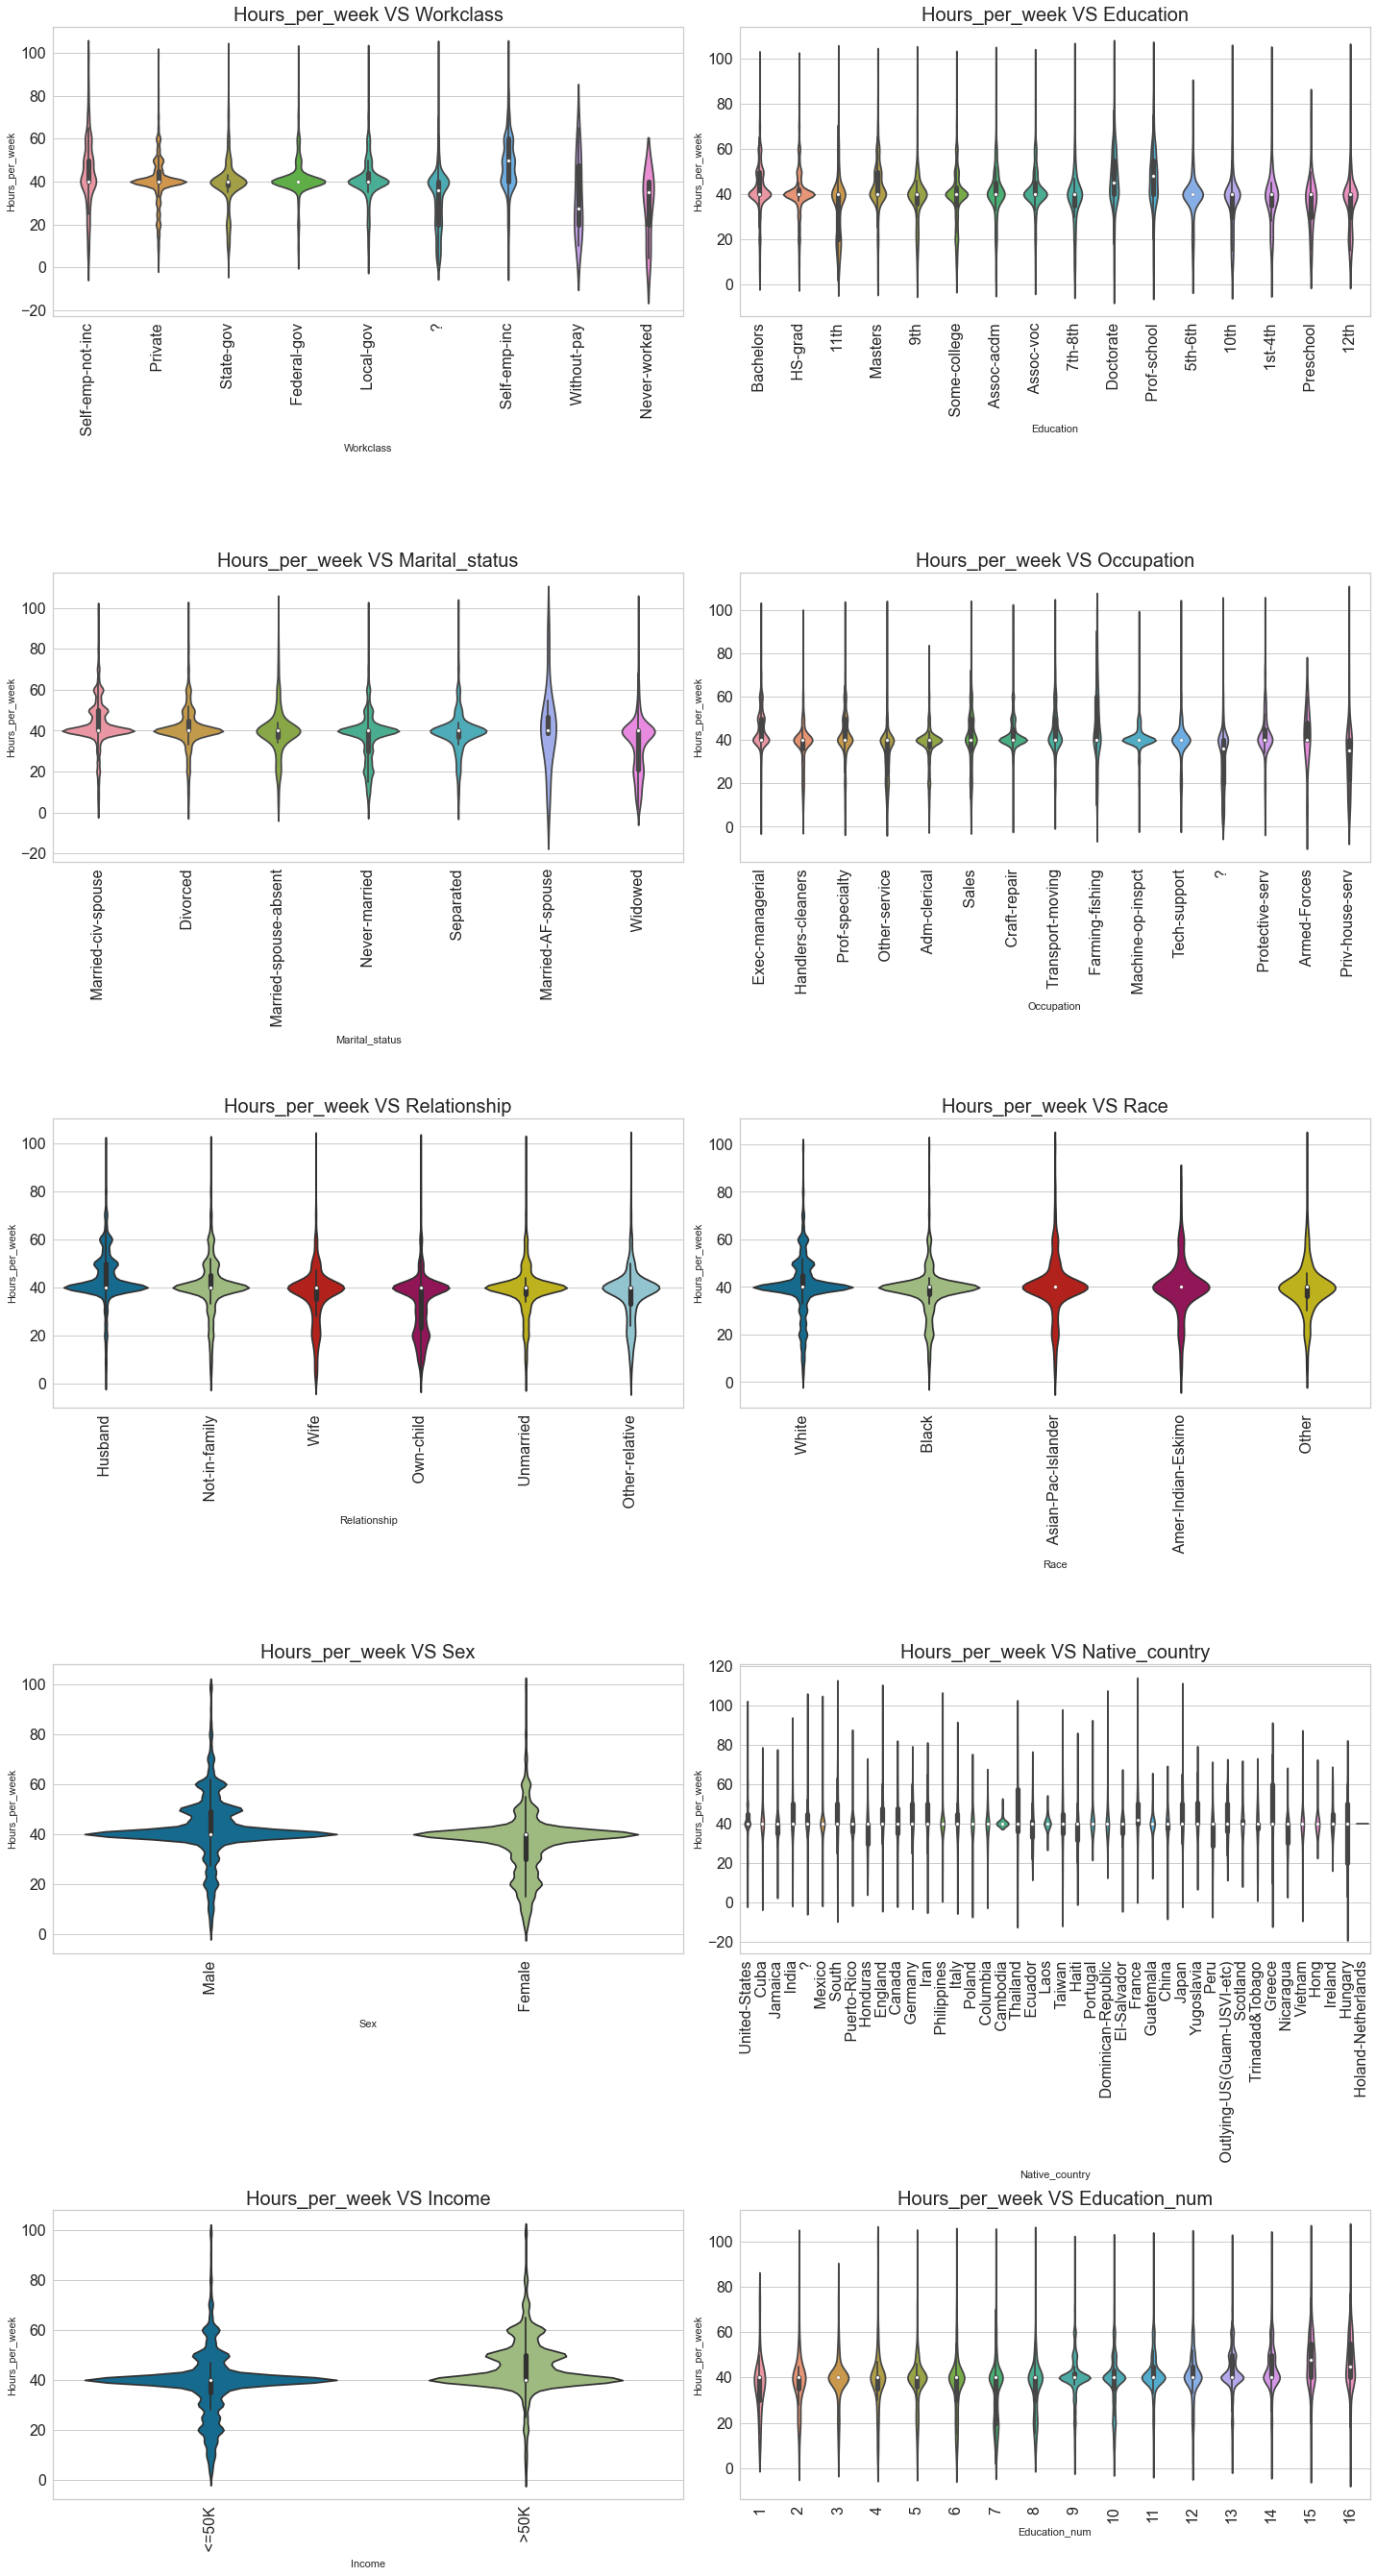

In [152]:
#Checking the relationship of Hour_per_week column with other object features using violinplot
col2=['Workclass','Education','Marital_status','Occupation','Relationship','Race','Sex','Native_country','Income','Education_num']

plt.figure(figsize=(20,60))
for i in range(len(col2)):
  plt.subplot(8,2,i+1)
  sns.violinplot(y=df['Hours_per_week'],x=df[col2[i]])
  plt.title(f"Hours_per_week VS {col2[i]}",fontsize=20)
  plt.xticks(rotation=90,fontsize=16)  
  plt.yticks(fontsize=16)
  plt.tight_layout()

Observations:

1. We see that Govt. Employees do not work more than 80 hours a week and that too in rare cases.

2. We can see that people with less education work higher number of hours per week.

3. It can be seen that Armed forces person doesnot work more than 60 hours a week while farmers and transport movers works more hours as compared to the other occupations.

4. More no. of individuals who have relationship like 'own-child' have high density of working only 20 hours a week.

5. It is seen that female works lesser no.of hours as compared to male.

6. From relationship, it can be see that people who are husband, works more as compared to others.

7. From Race, we can say that white people work more as compared to others.

8. From education, it can be seen that people who are prof. or are doing doctorate works higher no.of hours per week.

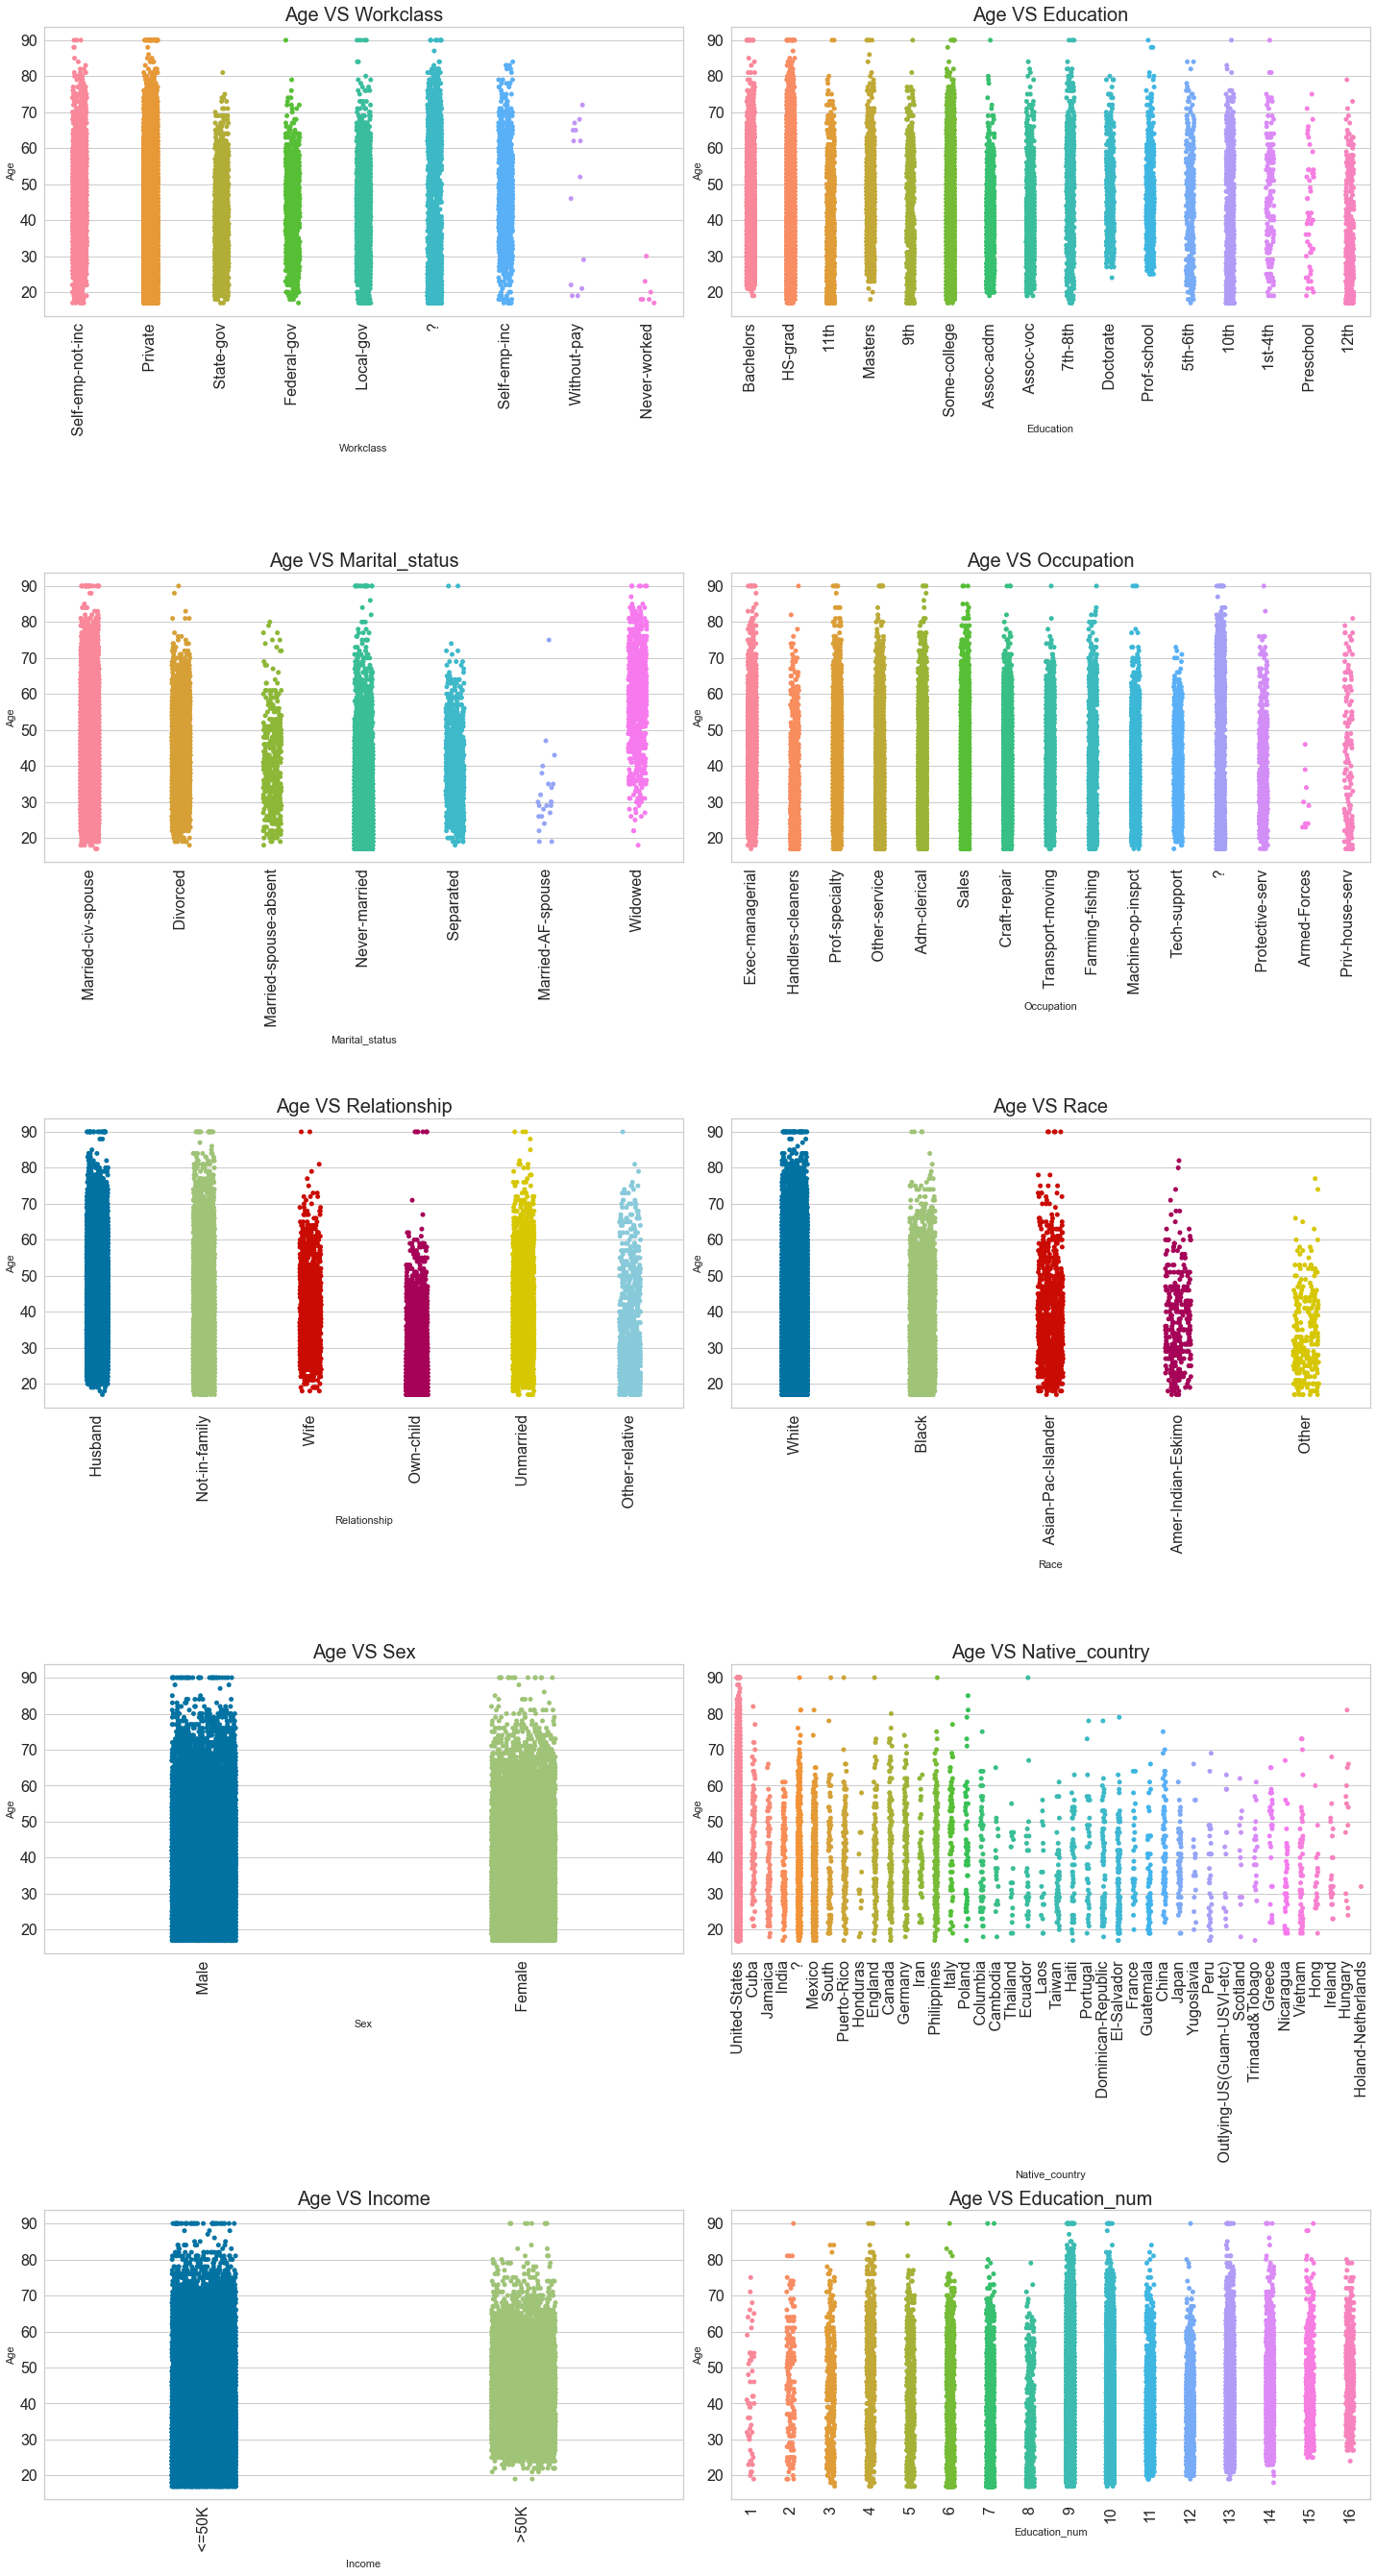

In [153]:
#checking the relationship of Age with other feature columns 
plt.figure(figsize=(20,60))
for i in range(len(col2)):
  plt.subplot(8,2,i+1)
  sns.stripplot(y=df['Age'],x=df[col2[i]])
  plt.title(f"Age VS {col2[i]}",fontsize=20)
  plt.xticks(rotation=90,fontsize=16)  
  plt.yticks(fontsize=16)
  plt.tight_layout()

Observations:

1. Individuals working in the govt. sector have almost age 70 to 80 with few outliers which must be the retirement age for them.

2. It is also seen that there are no individual who do not work after age of 30.

3. We can see that there are no individuals of age >70 belonging to the pre-school education category while doctorates and professors appears from late 20's as they have to study for more years to get to that level of education.

4. In the case of education_num, with increase in age education number increases.

5. There are no people after the age of 50 in the marital_status category from the Armed forces with just a few outliers.

7. With the increase in age, the number of widows increases.

8. Working men has higher age than working female.

8. People from US are higher who are working and falls into the age group from 15 to 85.

9. People from age group between 15 to 85 have income more or equal to 50k.

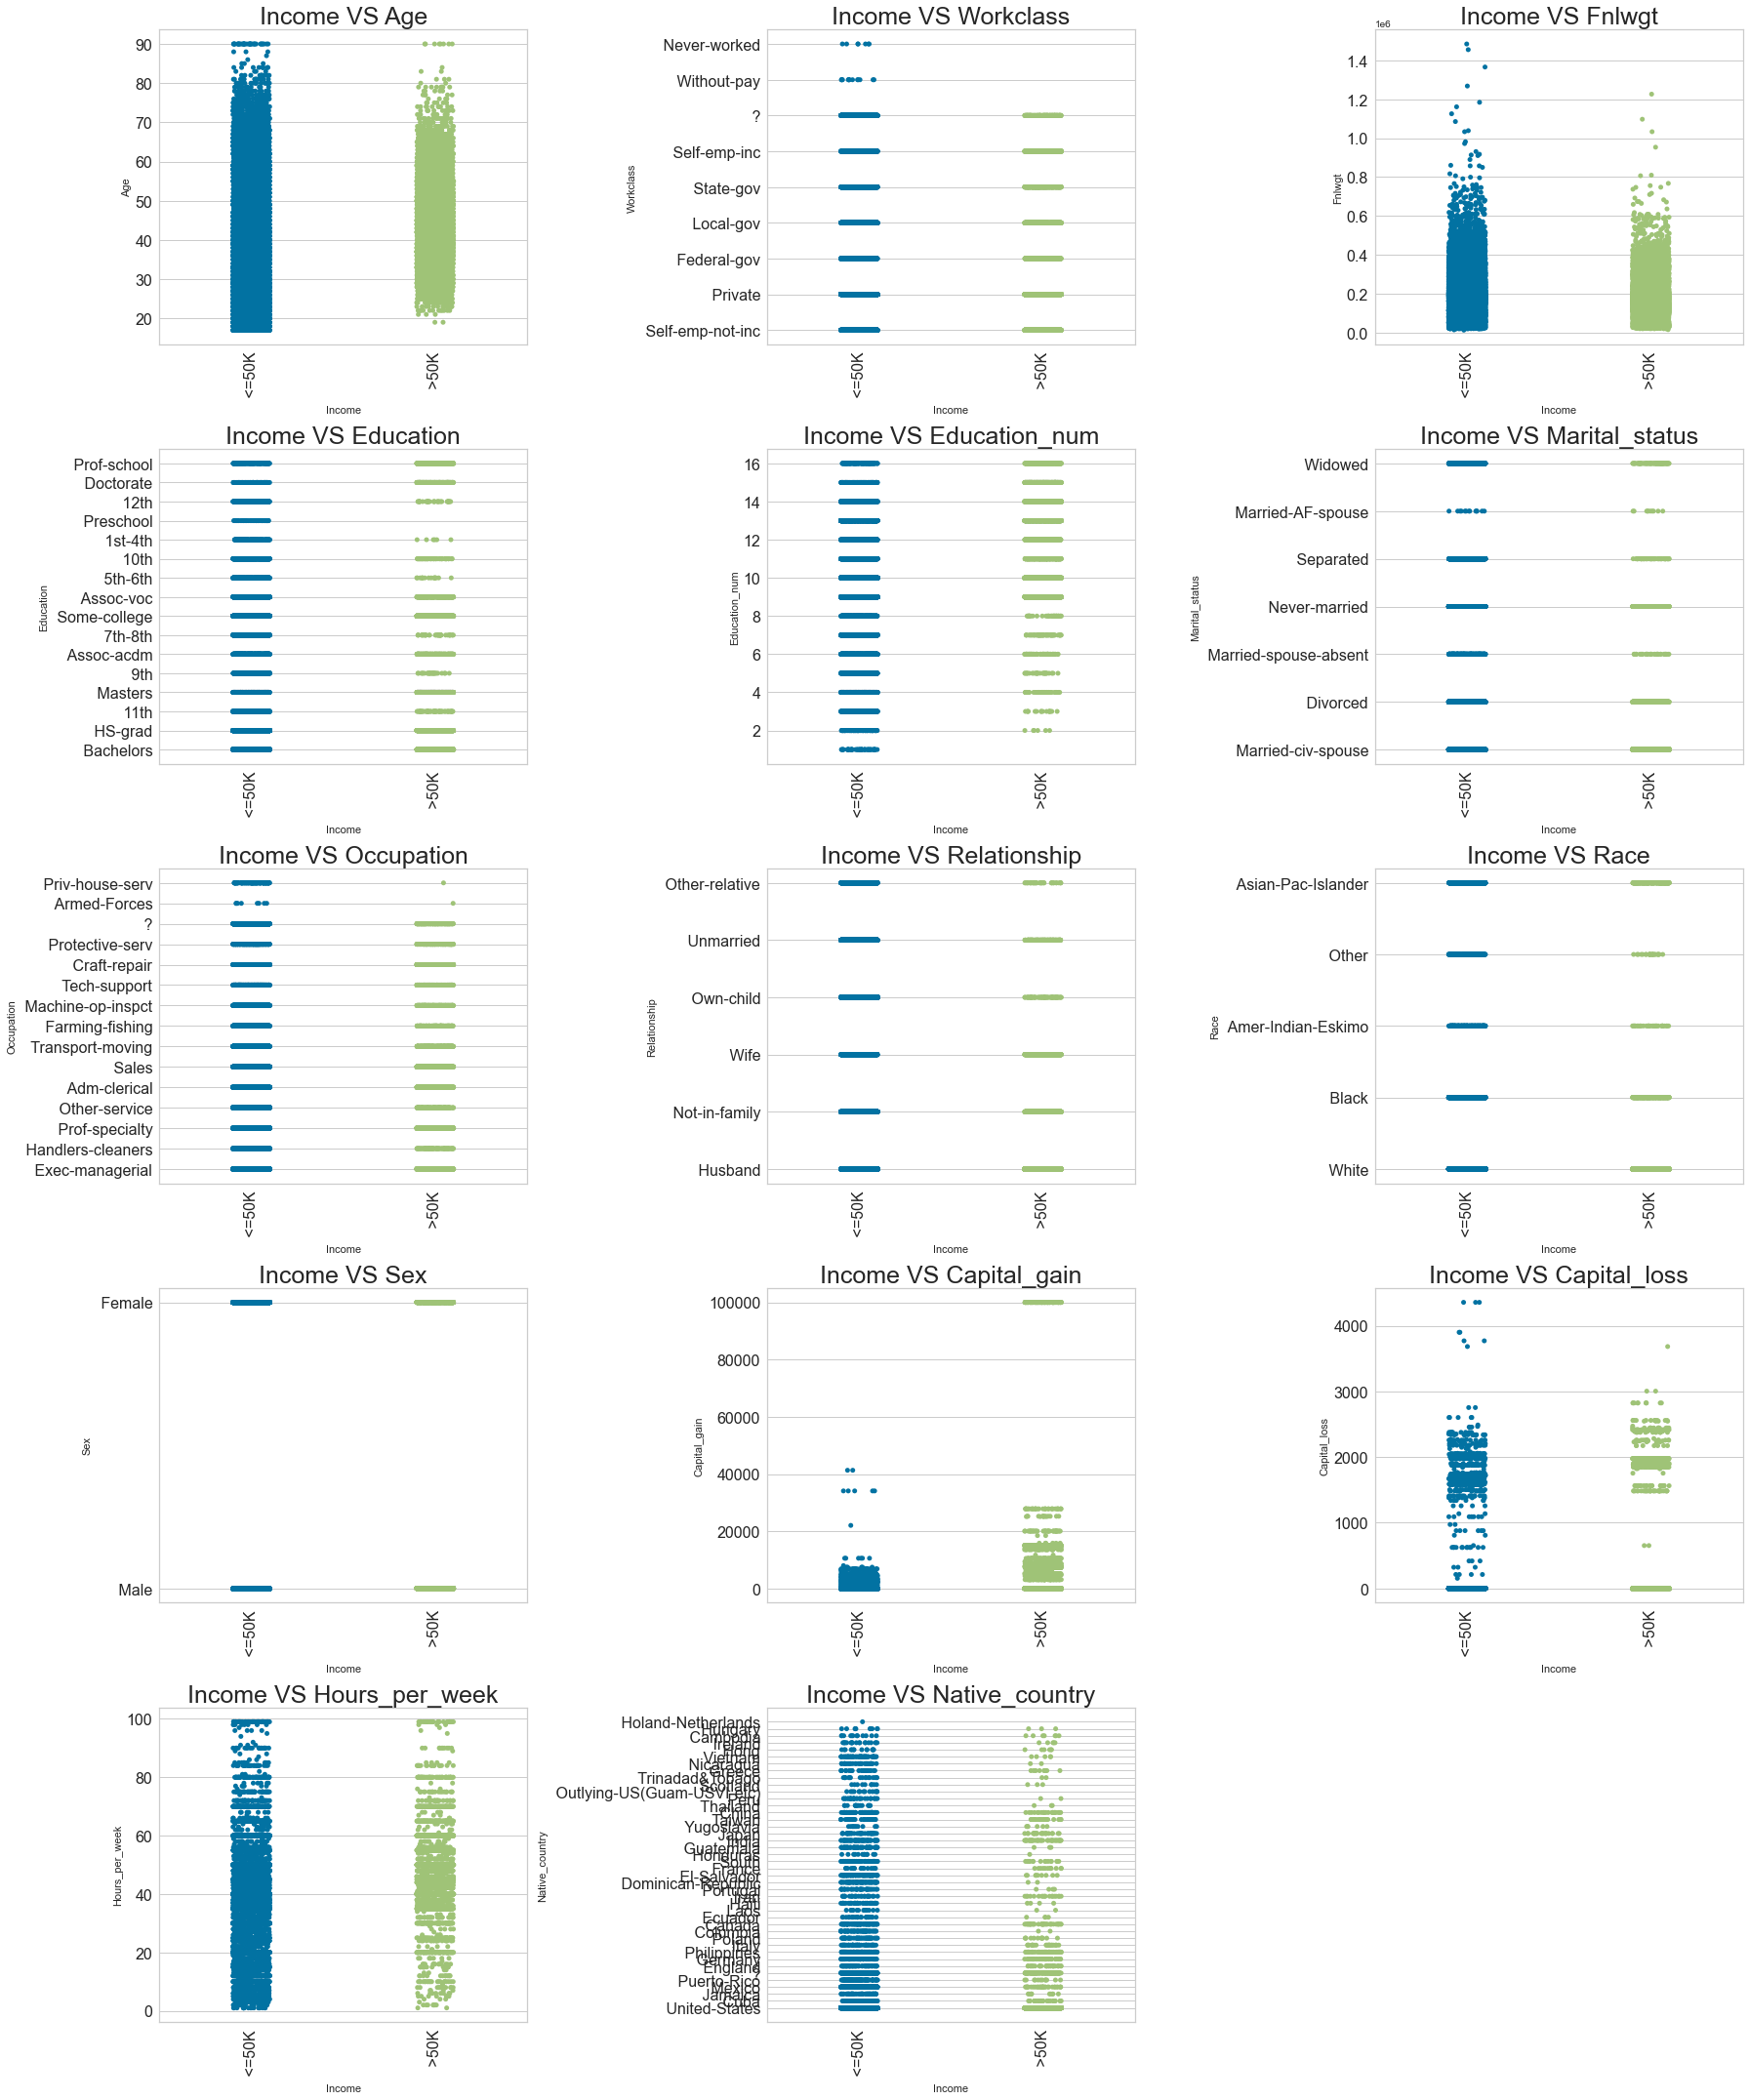

In [154]:
#Checking the relationship of our Target label Income with the feature columns using stripplot

col3=['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country']

plt.figure(figsize=(25,30))
for i in range(len(col3)):
  plt.subplot(5,3,i+1)
  sns.stripplot(x=df['Income'],y=df[col3[i]])
  plt.title(f"Income VS {col3[i]}",fontsize=25)
  plt.xticks(rotation=90,fontsize=16)  
  plt.yticks(fontsize=16)
  plt.tight_layout()

Observations:

1. From age, we can say that people from age 25-65 have high chances to earn more than 50k.

2. From workclass, we see that except for without pay and never worked, other workclass have chances to earn more than 50k.

3. From education it can be see that as the education increase, there are more chances to earn more than 50k. Same is the case with education_num.

4. From marital status, we see that except for married AF spouse, all have chances to earn more than 50k.

5. From occupation, we see that as the number of occupation increase, there are more chances to earn more than 50k

6. From relationship and sex, we can see that there is no such effect of relationship or sex on income.

7. From capital_gain, we see that higher the capital income is, higher is the chance to earn more than 50k

8. From capital_loss, we see that lesser the capital_loss more is the income.

9. Lets plot the last two plots separately to understand it clearly.

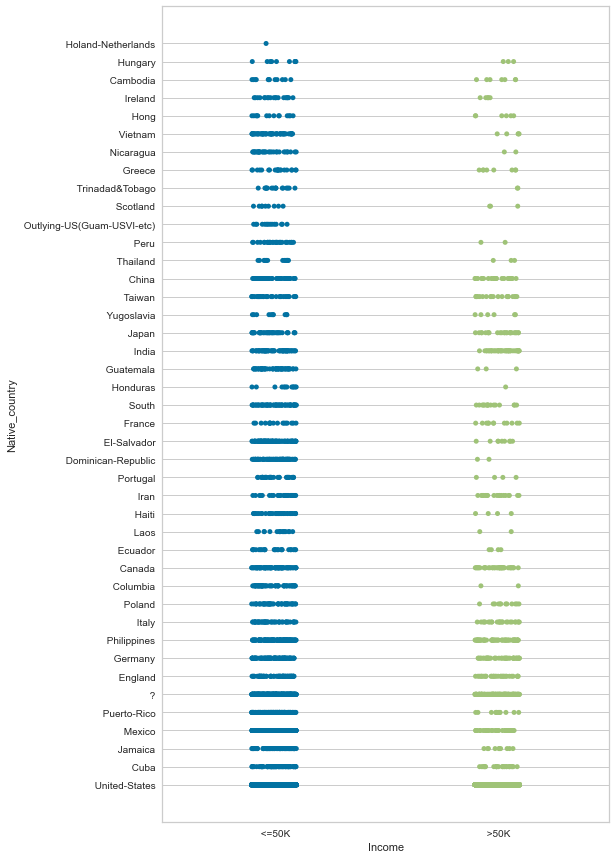

In [155]:
plt.figure(figsize=(8,15))
sns.stripplot(x = 'Income', y = 'Native_country', data=df)
plt.show()

Observations: The above plot shows that people belonging to different countries is less which are earning >50k because no.of individuals belonging from other countries other than U.S are very low but it can be see that that there are more people in the category <50k than >50k.

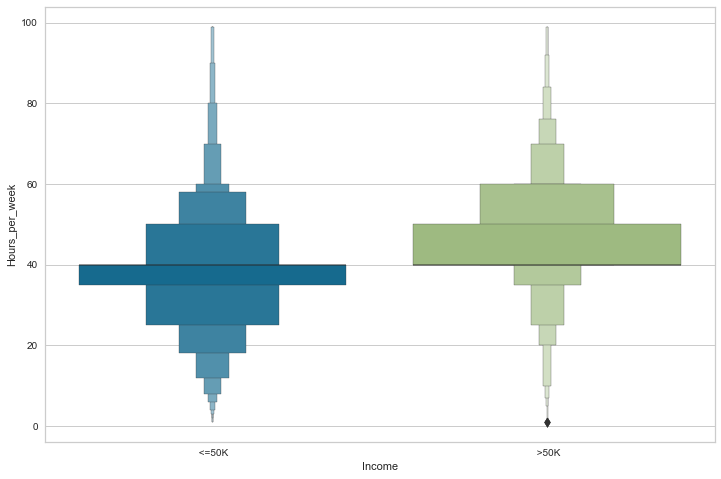

In [156]:
plt.figure(figsize=(12,8))
sns.boxenplot(x = 'Income', y = 'Hours_per_week', data=df)
plt.show()

Observations:

1. People earning >50k income work more hours per week than those earning <50k.

Text(0.5, 1.0, 'Income Vs Age')

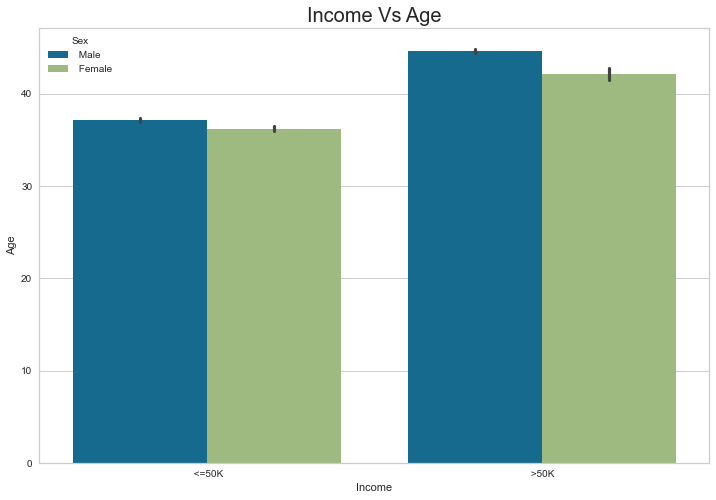

In [157]:
#Checking Income Vs age with barplot
plt.figure(figsize=(12,8))
sns.barplot(x='Income',y='Age',data=df,hue='Sex')
plt.title("Income Vs Age",fontsize=20)

Observation: The above plot shows as the age increases people are getting paid more but male are having higher income than their female counterparts.

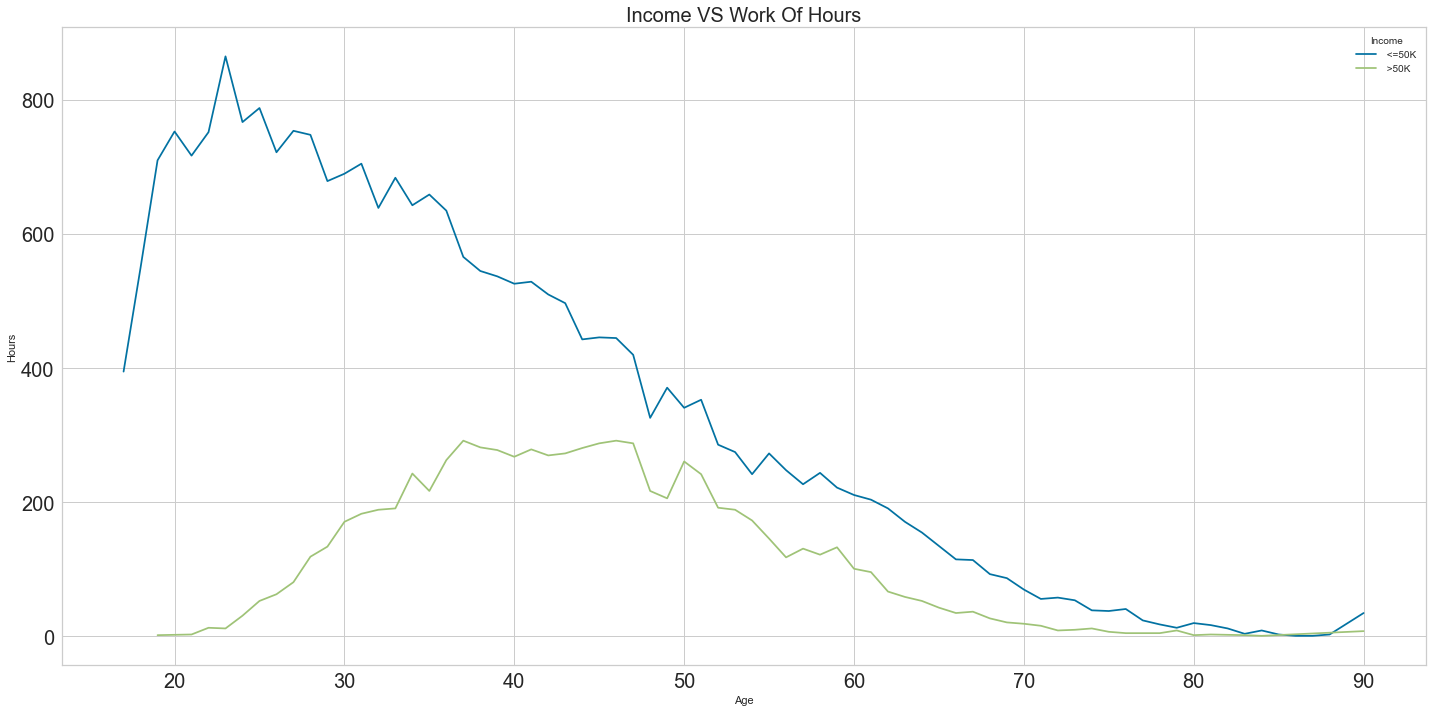

In [158]:
#Checking Income vs work per hour using lineplot
df1=df.groupby(['Age',"Income"]).apply(lambda x:x['Hours_per_week'].count()).reset_index(name='Hours')

plt.figure(figsize=(20,10))
sns.lineplot(x='Age',y='Hours',data=df1,hue='Income')
plt.title("Income VS Work Of Hours",fontsize=20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.tight_layout()

Observation: The above plot shows that People who get salary <50k have to work more hours and people who get salary >50k have to work less hours.

(array([0, 1]), [Text(0, 0, ' Male'), Text(1, 0, ' Female')])

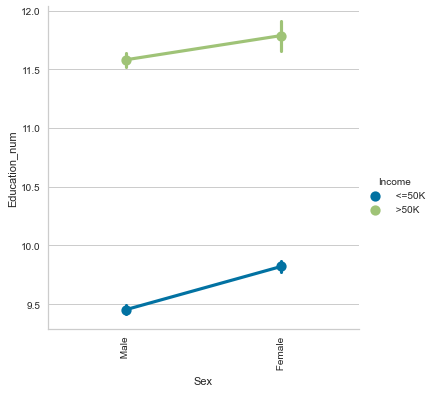

In [159]:
sns.factorplot(x='Sex',y='Education_num',data=df,hue='Income')
plt.xticks(rotation=90)

Observation: It can be see that Female with higher education level earn equal as men having less education level than them irrespective of any income category they fall.

<Figure size 864x576 with 0 Axes>

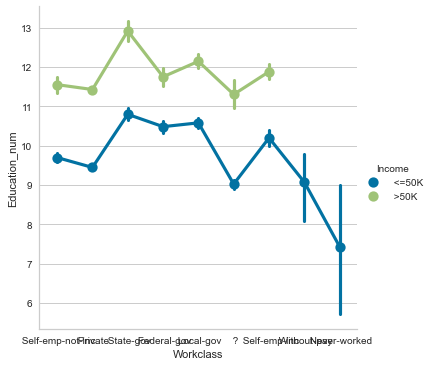

In [160]:
plt.figure(figsize=(12,8))
sns.factorplot(x='Workclass',y='Education_num',hue='Income',data=df)

Observation: It shows that some people belonging to a particular workclass might have less education and some workclass might require more education level but if they have higher education level they earn more. It can be also seenthat there is no person from without pay and never worked workclass category who earn more than 50k which is logical.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, ' Exec-managerial'),
  Text(1, 0, ' Handlers-cleaners'),
  Text(2, 0, ' Prof-specialty'),
  Text(3, 0, ' Other-service'),
  Text(4, 0, ' Adm-clerical'),
  Text(5, 0, ' Sales'),
  Text(6, 0, ' Craft-repair'),
  Text(7, 0, ' Transport-moving'),
  Text(8, 0, ' Farming-fishing'),
  Text(9, 0, ' Machine-op-inspct'),
  Text(10, 0, ' Tech-support'),
  Text(11, 0, ' ?'),
  Text(12, 0, ' Protective-serv'),
  Text(13, 0, ' Armed-Forces'),
  Text(14, 0, ' Priv-house-serv')])

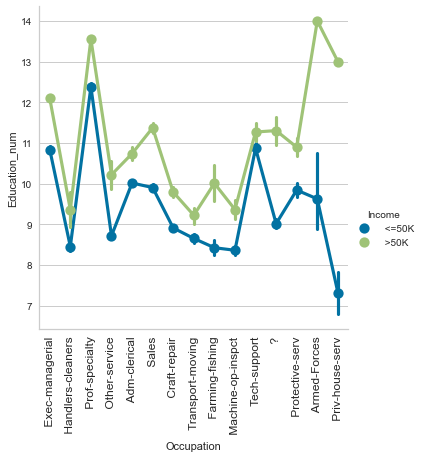

In [161]:
sns.factorplot(x='Occupation',y='Education_num',hue="Income",data=df)
plt.xticks(rotation=90,fontsize=12)

Obseravtion: From the above plot we can see that People with highest education level belong to armed forces,but people with even education level quite low, who belong to handlers cleaners,transport moving occupation earn as much as they do. Same is the case with prof speciality. occupation of private house service who earn >50k and <50k have the highest education level as same as prof speciality having a very tiny difference.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, ' White'),
  Text(1, 0, ' Black'),
  Text(2, 0, ' Asian-Pac-Islander'),
  Text(3, 0, ' Amer-Indian-Eskimo'),
  Text(4, 0, ' Other')])

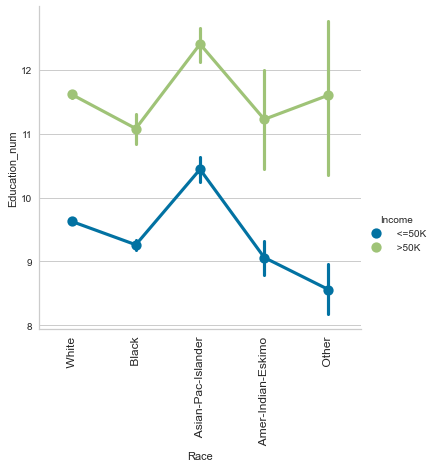

In [162]:
sns.factorplot(x='Race',y='Education_num',hue='Income',data=df)
plt.xticks(rotation=90,fontsize=12)

Obseravtion: We can see from the above plot that Asian pacific race have comparatively higher education than the fellows who earn same as much as they do,belonging to other races. Indians and some other races earns >50k with lowest education level.

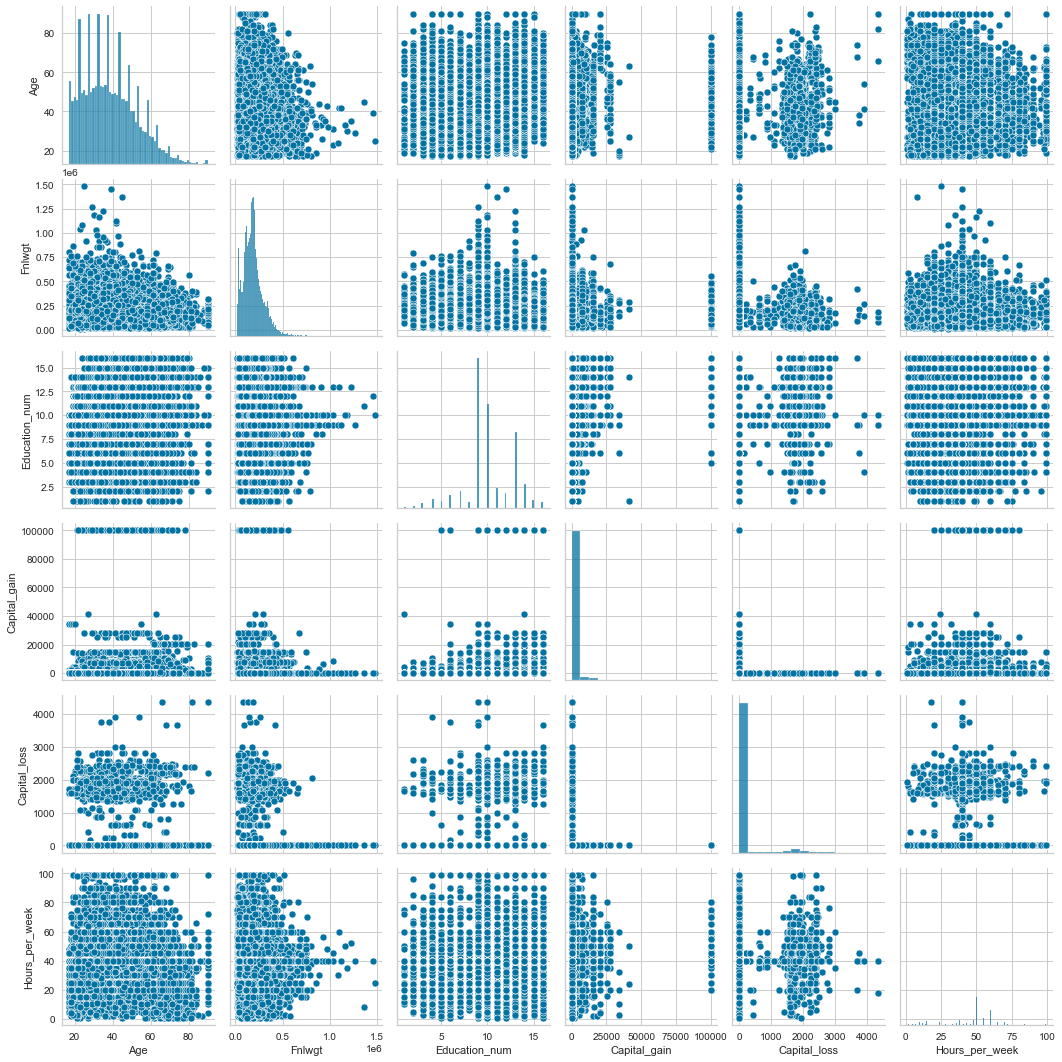

In [163]:
#checking the pairplot of the feature columns
sns.pairplot(df)

Observation:  We generated the above pairplot for our continous data columns and it shows how the data points are available in each of them.

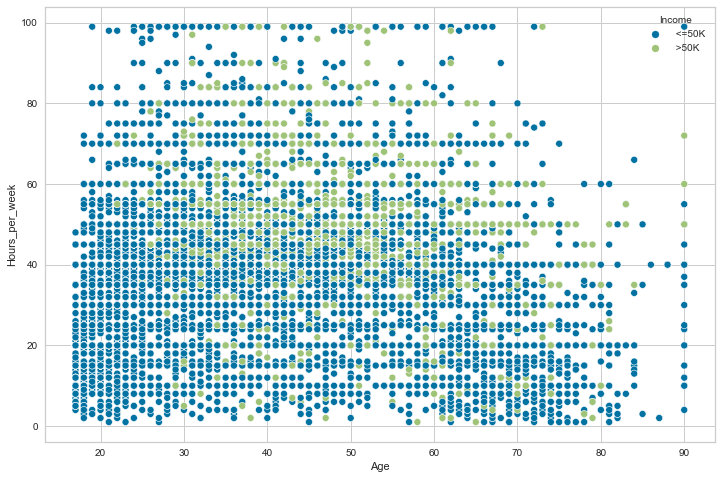

In [164]:
#Checking the realtionship of age and  hours_per_ week with income using scatterplot
plt.figure(figsize=(12,8))
sns.scatterplot(x='Age',y='Hours_per_week',data=df,hue='Income')
plt.show()

Obseravtion:

From the plot above, we can see that between age, Hours_per_week and income, a person need to be >30 years of age to earn more than 50k, or else needs to work at least 50 hours per week to earn >50k.

# Encoding:

In [165]:
Oe=OrdinalEncoder()
def ordinal_encoder(df,column):
  df[column]=Oe.fit_transform(df[column])
  return df

Remarks: We are using ordinalencoder because every column except Native_country are in order.

In [166]:
df=ordinal_encoder(df,['Education','Income','Marital_status','Occupation','Race','Relationship','Sex','Workclass'])
df

Age  Workclass  Fnlwgt  Education  Education_num  Marital_status  \
0       50        6.0   83311        9.0             13             2.0   
1       38        4.0  215646       11.0              9             0.0   
2       53        4.0  234721        1.0              7             2.0   
3       28        4.0  338409        9.0             13             2.0   
4       37        4.0  284582       12.0             14             2.0   
...    ...        ...     ...        ...            ...             ...   
32555   27        4.0  257302        7.0             12             2.0   
32556   40        4.0  154374       11.0              9             2.0   
32557   58        4.0  151910       11.0              9             6.0   
32558   22        4.0  201490       11.0              9             4.0   
32559   52        5.0  287927       11.0              9             2.0   

       Occupation  Relationship  Race  Sex  Capital_gain  Capital_loss  \
0             4.0           0.0   4.0  1.0             0             0   
1             6.0           1.0   4.0  1.0             0             0   
2             6.0           0.0   2.0  1.0             0             0   
3            10.0           5.0   2.0  0.0             0             0   
4             4.0           5.0   4.0  0.0             0             0   
...           ...           ...   ...  ...           ...           ...   
32555        13.0           5.0   4.0  0.0             0             0   
32556         7.0           0.0   4.0  1.0             0             0   
32557         1.0           4.0   4.0  0.0             0             0   
32558         1.0           3.0   4.0  1.0             0             0   
32559         4.0           5.0   4.0  0.0         15024             0   

       Hours_per_week  Native_country  Income  
0                  13   United-States     0.0  
1                  40   United-States     0.0  
2                  40   United-States     0.0  
3                  40            Cuba     0.0  
4                  40   United-States     0.0  
...               ...             ...     ...  
32555              38   United-States     0.0  
32556              40   United-States     1.0  
32557              40   United-States     0.0  
32558              20   United-States     0.0  
32559              40   United-States     1.0  

[32560 rows x 15 columns]

In [167]:
def preprocessing(df):
  df=df.copy()
  le=LabelEncoder()
  df['Native_country']=le.fit_transform(df['Native_country'])
  x=df.drop('Income',axis=1)
  y=df['Income']
  return x,y

Remarks: Using labelencoder because unique values are only 42 in Native_country. We are not using onehot here because it will increase the dimension size and even for model building more time and computation power will be required.

In [168]:
#pre-processing the data
x,y=preprocessing(df)
x

Age  Workclass  Fnlwgt  Education  Education_num  Marital_status  \
0       50        6.0   83311        9.0             13             2.0   
1       38        4.0  215646       11.0              9             0.0   
2       53        4.0  234721        1.0              7             2.0   
3       28        4.0  338409        9.0             13             2.0   
4       37        4.0  284582       12.0             14             2.0   
...    ...        ...     ...        ...            ...             ...   
32555   27        4.0  257302        7.0             12             2.0   
32556   40        4.0  154374       11.0              9             2.0   
32557   58        4.0  151910       11.0              9             6.0   
32558   22        4.0  201490       11.0              9             4.0   
32559   52        5.0  287927       11.0              9             2.0   

       Occupation  Relationship  Race  Sex  Capital_gain  Capital_loss  \
0             4.0           0.0   4.0  1.0             0             0   
1             6.0           1.0   4.0  1.0             0             0   
2             6.0           0.0   2.0  1.0             0             0   
3            10.0           5.0   2.0  0.0             0             0   
4             4.0           5.0   4.0  0.0             0             0   
...           ...           ...   ...  ...           ...           ...   
32555        13.0           5.0   4.0  0.0             0             0   
32556         7.0           0.0   4.0  1.0             0             0   
32557         1.0           4.0   4.0  0.0             0             0   
32558         1.0           3.0   4.0  1.0             0             0   
32559         4.0           5.0   4.0  0.0         15024             0   

       Hours_per_week  Native_country  
0                  13              39  
1                  40              39  
2                  40              39  
3                  40               5  
4                  40              39  
...               ...             ...  
32555              38              39  
32556              40              39  
32557              40              39  
32558              20              39  
32559              40              39  

[32560 rows x 14 columns]

# Multivariate Analysis:

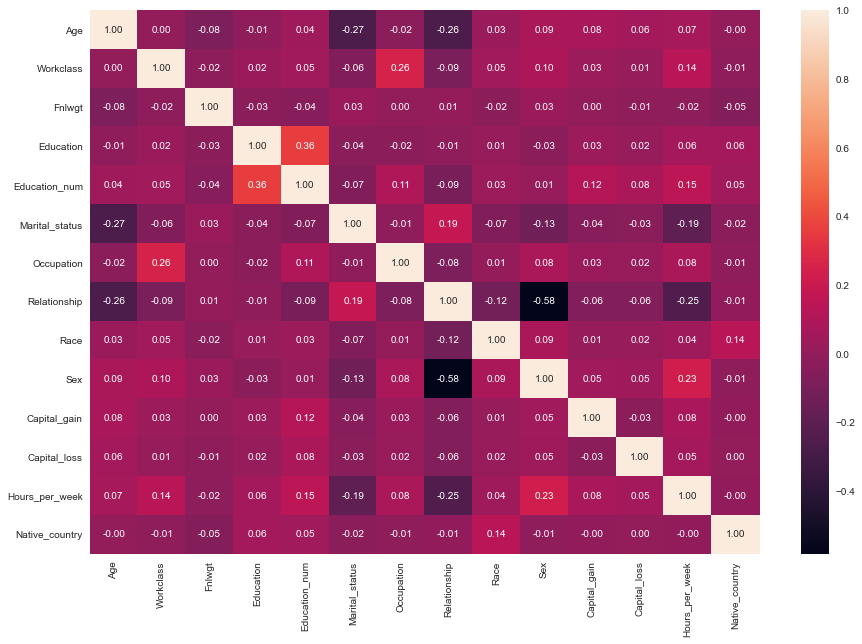

In [169]:
#Checking Correlation using heatmap
x_corr=x.corr()
plt.figure(figsize=(15,10))
sns.heatmap(x_corr,annot=True,fmt='.2f')
plt.show()

Observation: From the above visualization, we see that Correlation seems to be good like education having good +ve correlation; and relationship and sex having -ve correlation and rest of the columns are also having correlation but at low level.

# Checking Outliers:

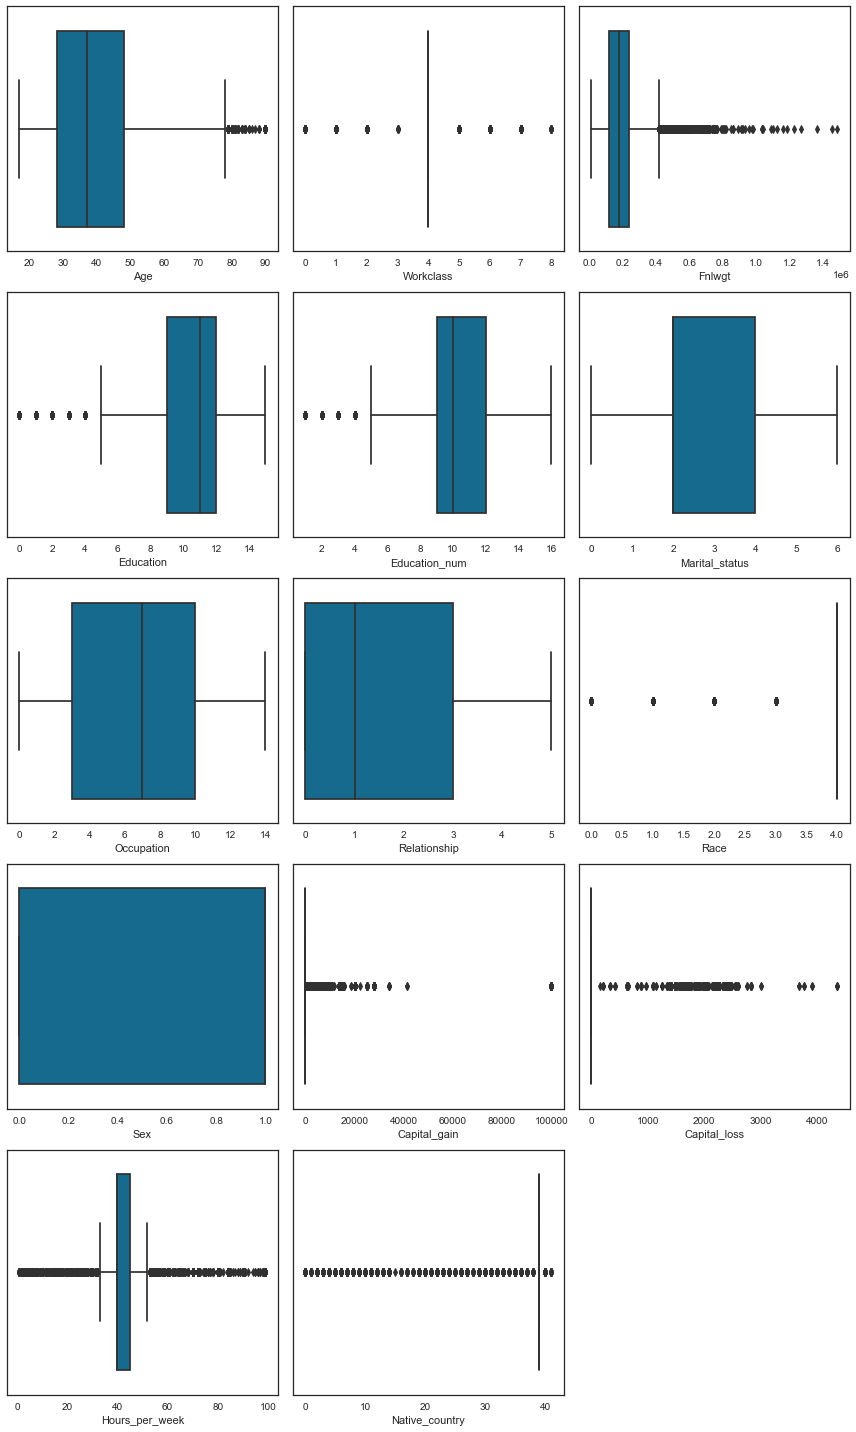

In [172]:
#checking outliers in our dataset with boxplot
X_val=x.columns.values
plt.figure(figsize=(12,20))
for i in range(len(X_val)):
  plt.subplot(5,3,i+1)
  sns.boxplot(x[X_val[i]])
  plt.tight_layout()

Observation: It can be seen from the above boxplots that there are outliers present.

# Removing Outliers:

In [173]:
for col in x.columns:
  percentile=x[col].quantile([0.01,0.98]).values
  x[col][x[col]<=percentile[0]]=percentile[0]
  x[col][x[col]>=percentile[1]]=percentile[1]

Remarks: Here we have removed the outliers with the percentile method.

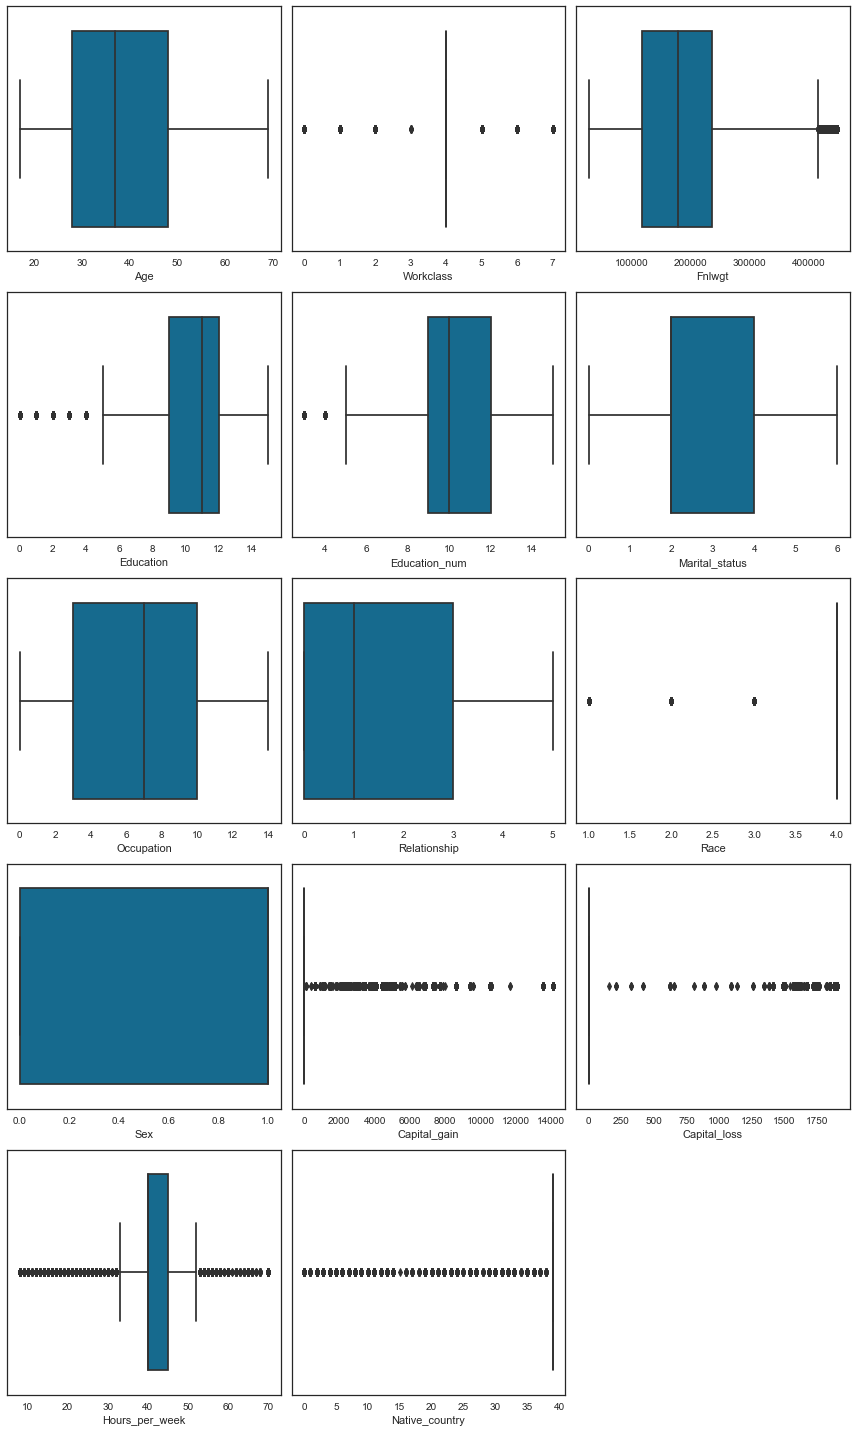

In [174]:
#checking outliers after removal
X_val=x.columns.values
plt.figure(figsize=(12,20))
for i in range(len(X_val)):
  plt.subplot(5,3,i+1)
  sns.boxplot(x[X_val[i]])
  plt.tight_layout()

Remarks: As it can be seen from the above plots that we have removed many outliers.

# Balancing the imbalanced data:

Note: Our dataset contains imbalanced data so we are going to use SMOTE technique to balance the imbalnced data.

In [175]:
smote=SMOTE(random_state=42)
X_res,y_res=smote.fit_resample(x,y)
X_new=pd.DataFrame(X_res,columns=x.columns)
y_new=pd.DataFrame(y_res,columns=['Income'])

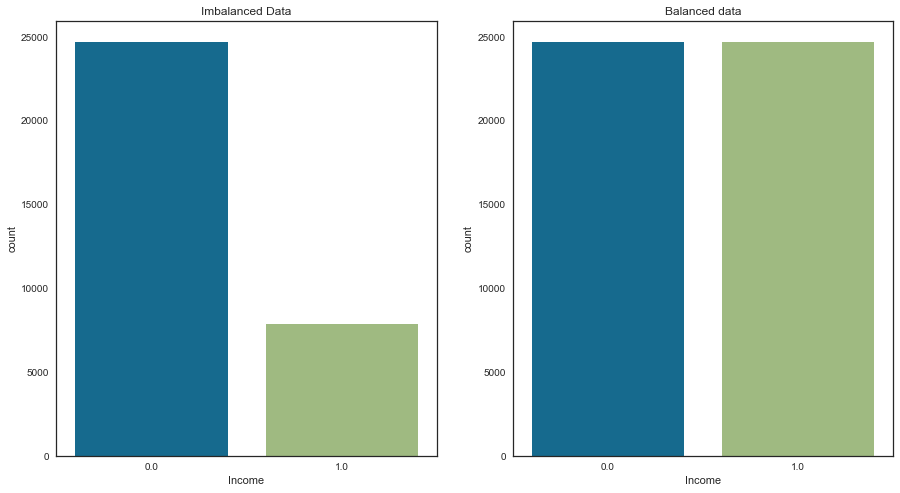

In [176]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.countplot(df['Income'])
plt.title("Imbalanced Data")
plt.subplot(1,2,2)
sns.countplot(y_new['Income'])
plt.title("Balanced data")
plt.show()

Remarks: We can see that data has been balanced.

In [177]:
#checking the shape of data before and after balancing
print(df.shape)
print(X_new.shape)

(32560, 15)
(49438, 14)


# Checking skewness:

In [178]:
x.skew()

Age                0.558738
Workclass         -0.752280
Fnlwgt             1.446972
Education         -0.934063
Education_num     -0.311630
Marital_status    -0.013448
Occupation         0.114540
Relationship       0.786784
Race              -2.435332
Sex               -0.719244
Capital_gain      11.953690
Capital_loss       4.594549
Hours_per_week     0.227636
Native_country    -3.658235
dtype: float64

Remarks: There is skewed data in our dataset.

In [179]:
#Removing skewness with power-transform technique
X_new=power_transform(X_new,method='yeo-johnson')
X_new=pd.DataFrame(X_new,columns=x.columns)

In [180]:
X_new.skew()

Age              -0.041028
Workclass         0.084600
Fnlwgt           -0.031511
Education        -0.208042
Education_num    -0.023093
Marital_status    0.004875
Occupation       -0.177783
Relationship      0.290579
Race             -2.003784
Sex              -0.962074
Capital_gain      2.247807
Capital_loss      3.547217
Hours_per_week    0.121618
Native_country   -2.555819
dtype: float64

Remarks: From the above cell, we see that skewness has been removed.

# Feature Scaling:

In [182]:
scaler=StandardScaler()
X_new=scaler.fit_transform(X_new)
X_new=pd.DataFrame(X_new,columns=x.columns)

# Splitting data for model building using train test split:

In [183]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y_new,test_size=0.3,random_state=42)

# Finding the best model:

In [186]:
models={
    "LogisticRegression":LogisticRegression(),
    "DecisionTreeClassifier":DecisionTreeClassifier(),
    "RandomForestClassifier":RandomForestClassifier(),
    "ExtraTreesClassifier":ExtraTreesClassifier(),
    "XGBClassifier":XGBClassifier(),
    "LGBMClassifier":LGBMClassifier()
}

In [187]:
#using stratifiedkfold here because it selects all classes at equal level
skf=StratifiedKFold(n_splits=5,shuffle=True)

*************************************************** LogisticRegression ************************************************************


Accuracy_Score 0.7688781014023732


SCORE 0.7688781014023732


Confusion metrics


[[5542 1867]
 [1561 5862]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.78      0.75      0.76      7409
         1.0       0.76      0.79      0.77      7423

    accuracy                           0.77     14832
   macro avg       0.77      0.77      0.77     14832
weighted avg       0.77      0.77      0.77     14832

Cross_Val_Score 0.766474982021765


ROC AUC CURVE


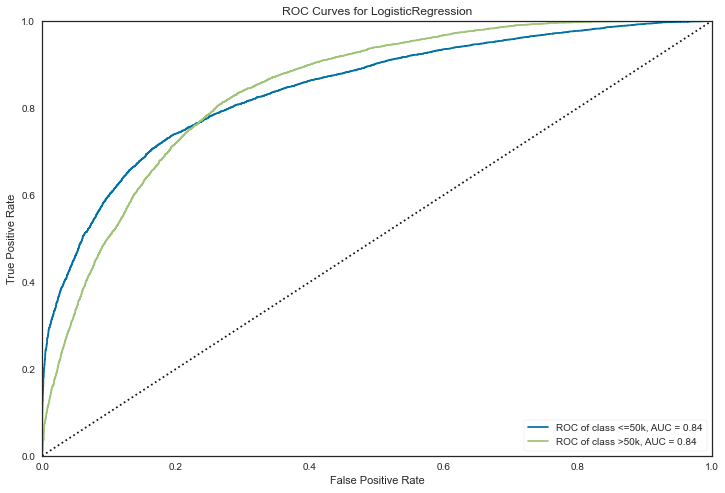

MODEL LEARNING CURVE


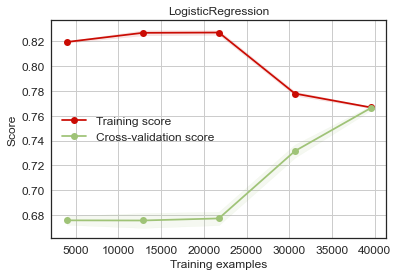

*************************************************** DecisionTreeClassifier ************************************************************


Accuracy_Score 0.8634708737864077


SCORE 0.8634708737864077


Confusion metrics


[[6355 1054]
 [ 971 6452]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      7409
         1.0       0.86      0.87      0.86      7423

    accuracy                           0.86     14832
   macro avg       0.86      0.86      0.86     14832
weighted avg       0.86      0.86      0.86     14832

Cross_Val_Score 0.8627168680850896


ROC AUC CURVE


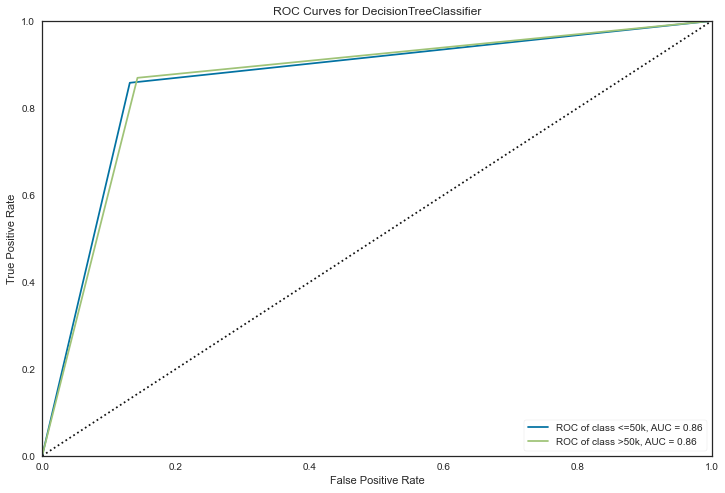

MODEL LEARNING CURVE


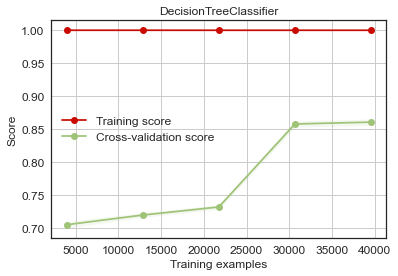

*************************************************** RandomForestClassifier ************************************************************


Accuracy_Score 0.9008225458468176


SCORE 0.9008225458468176


Confusion metrics


[[6745  664]
 [ 807 6616]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      7409
         1.0       0.91      0.89      0.90      7423

    accuracy                           0.90     14832
   macro avg       0.90      0.90      0.90     14832
weighted avg       0.90      0.90      0.90     14832

Cross_Val_Score 0.9000767961950625


ROC AUC CURVE


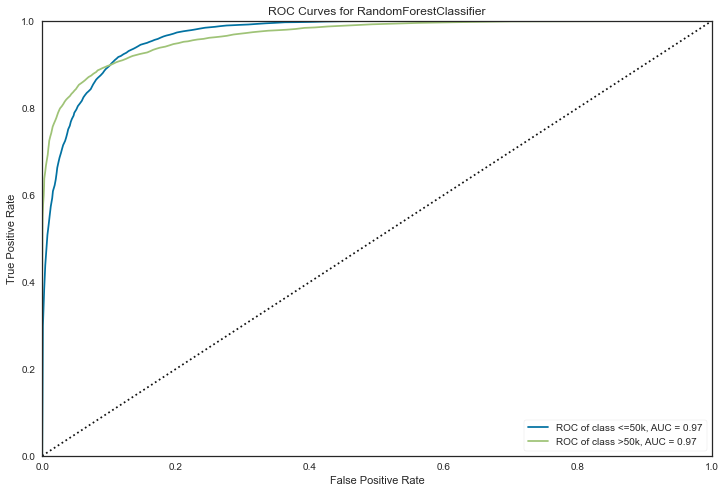

MODEL LEARNING CURVE


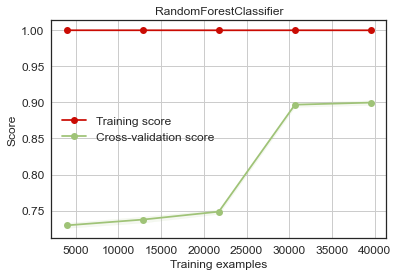

*************************************************** ExtraTreesClassifier ************************************************************


Accuracy_Score 0.8972491909385113


SCORE 0.8972491909385113


Confusion metrics


[[6636  773]
 [ 751 6672]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      7409
         1.0       0.90      0.90      0.90      7423

    accuracy                           0.90     14832
   macro avg       0.90      0.90      0.90     14832
weighted avg       0.90      0.90      0.90     14832

Cross_Val_Score 0.8954447452818795


ROC AUC CURVE


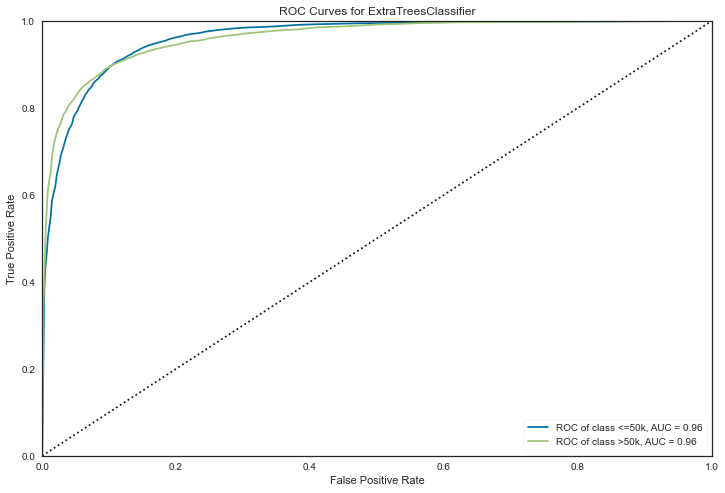

MODEL LEARNING CURVE


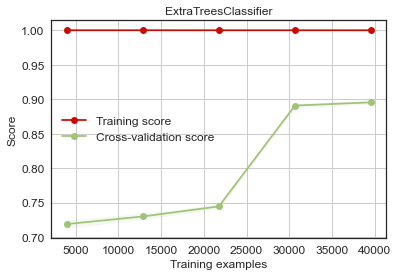

*************************************************** XGBClassifier ************************************************************
[03:53:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy_Score 0.9103964401294499


SCORE 0.9103964401294499


Confusion metrics


[[6860  549]
 [ 780 6643]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      7409
         1.0       0.92      0.89      0.91      7423

    accuracy                           0.91     14832
   macro avg       0.91      0.91      0.91     14832
weighted avg       0.91      0.91      0.91     14832

[03:53:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095

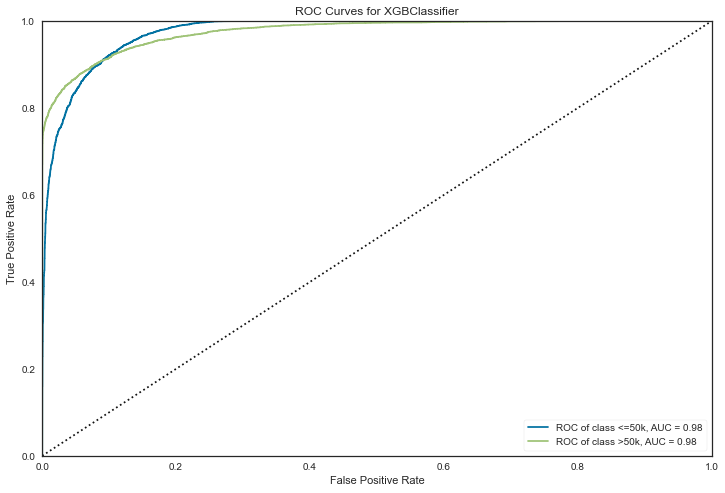

MODEL LEARNING CURVE
[03:54:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:54:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:54:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:54:19] WARNING: C:/Users/Administrator/worksp

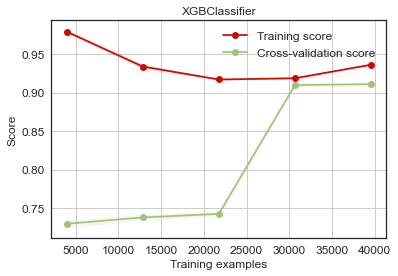

*************************************************** LGBMClassifier ************************************************************


Accuracy_Score 0.9138349514563107


SCORE 0.9138349514563107


Confusion metrics


[[6895  514]
 [ 764 6659]]
CLASSIFICATION REPORT


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      7409
         1.0       0.93      0.90      0.91      7423

    accuracy                           0.91     14832
   macro avg       0.91      0.91      0.91     14832
weighted avg       0.91      0.91      0.91     14832

Cross_Val_Score 0.9126987548292469


ROC AUC CURVE


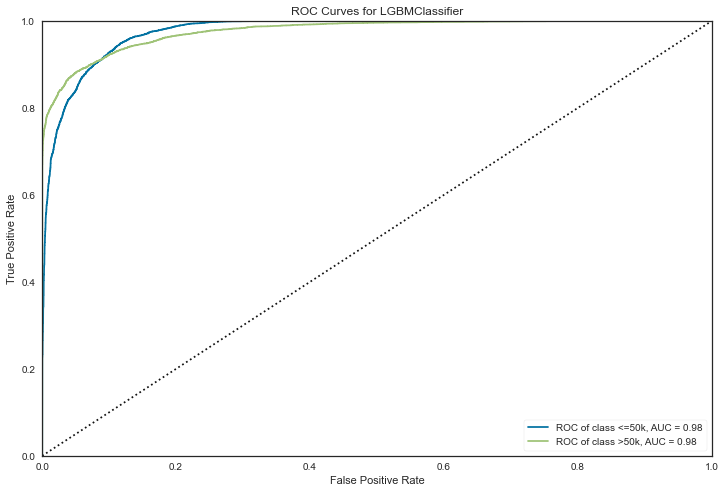

MODEL LEARNING CURVE


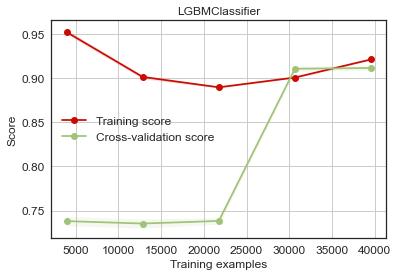

In [188]:
Score=[]
CVS=[]
MODEL=[]
for name,model in models.items():
  print("***************************************************",name,"************************************************************")
  MODEL.append(name)
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  print('\n')
  ac=accuracy_score(y_test,y_pred)
  Score.append(ac)
  print("Accuracy_Score",ac)
  print('\n')
  print("SCORE",model.score(X_test,y_test))
  print("\n")
  cm=confusion_matrix(y_test,y_pred)
  print('Confusion metrics')
  print('\n')
  print(cm)
  print("CLASSIFICATION REPORT")
  report=classification_report(y_test,y_pred)
  print('\n')
  print(report)
  csv=cross_val_score(model,X_new,y_new,cv=skf).mean()
  CVS.append(csv*100)
  print("Cross_Val_Score",csv)
  print('\n')
  print("ROC AUC CURVE")
  plt.figure(figsize=(12,8))
  roc_auc(model,X_train,y_train,X_test=X_test,y_test=y_test,classes=['<=50k','>50k'],micro=False,macro=False)
  print("MODEL LEARNING CURVE")
  skplt.estimators.plot_learning_curve(model,X_new,y_new,cv=skf,scoring='accuracy',text_fontsize='large',title=name)
  plt.show()

# Remarks: LGBMclassifier is giving us good matrics and Cross_val_score of 0.91 so we are proceeding with this model for hyperparameter tuning.

In [190]:
lgb=LGBMClassifier()
lgb.fit(X_train,y_train)

LGBMClassifier()

In [191]:
y_pred=lgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.9138349514563107

In [192]:
lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# Hyperparameter tuning our best ML model:

In [193]:
param={
    'boosting_type': ['gbdt','dart','gross','rf'],
    'n_estimators':[100,500],
    'learning_rate':[0.1,0.01,0.001],
    'importance_type': ['split','gain'],
}

In [194]:
Grid=GridSearchCV(estimator=lgb,scoring='accuracy',param_grid=param,n_jobs=-1,cv=skf)

Remarks: Using the Grid Search CV method for hyperparameter tuning of the best model.

In [195]:
Grid.fit(X_new,y_new)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart', 'gross', 'rf'],
                         'importance_type': ['split', 'gain'],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [100, 500]},
             scoring='accuracy')

Remarks: We have trained the Grid Search CV with the list of parameters we think it should check for best possible outcomes.

In [196]:
Grid.best_params_

{'boosting_type': 'dart',
 'importance_type': 'split',
 'learning_rate': 0.1,
 'n_estimators': 500}

In [197]:
Grid.best_score_

0.9134471264774149

# Remarks: 
After successfully incorporating the Hyper Parameter Tuning on the Final Model we received the accuracy score for it i.e., 91.34%

In [198]:
LGBM=LGBMClassifier(boosting_type= 'dart',
 importance_type= 'split',
 learning_rate= 0.1,
 n_estimators= 500)

# Final Model Cross_val_score:

In [199]:
New_csv=cross_val_score(LGBM,X_new,y_new,cv=skf).mean()
New_csv

0.9125977039740001

In [200]:
LGBM.fit(X_train,y_train)
Y_Pred=LGBM.predict(X_test)
print(accuracy_score(y_test,Y_Pred))

0.9145091693635383


Remarks: Our Cross_val_score increased from 91.34% to 91.45%

# ROC AUC curve of final ML model:

ROC AUC CURVE


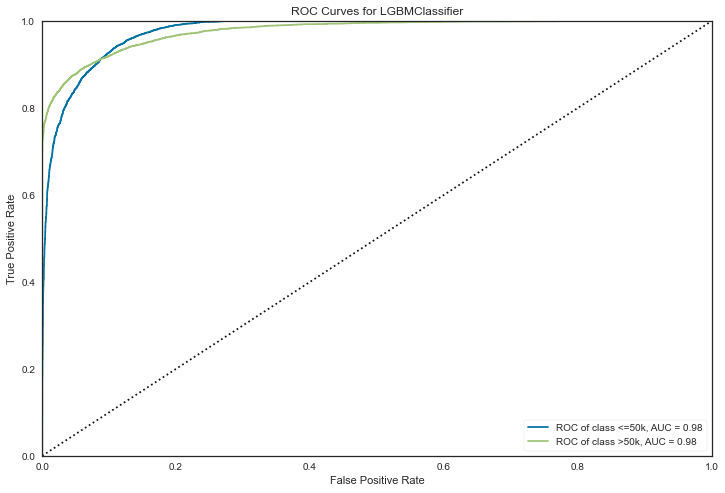

MODEL LEARNING CURVE


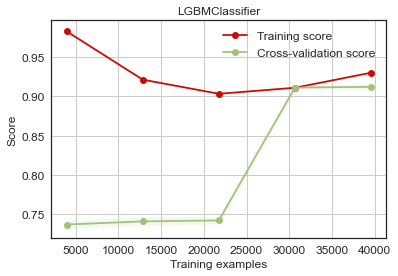

In [201]:
print("ROC AUC CURVE")
plt.figure(figsize=(12,8))
roc_auc(LGBM,X_train,y_train,X_test=X_test,y_test=y_test,classes=['<=50k','>50k'],micro=False,macro=False)
print("MODEL LEARNING CURVE")
skplt.estimators.plot_learning_curve(LGBM,X_new,y_new,cv=skf,scoring='accuracy',text_fontsize='large',title=name)
plt.show()

Remarks: 
We have generated the ROC Curve for the final model and it shows the AUC score for the final model to be of 98% for both income greater or equal or less than 50k.

# Final model Matrix:

In [202]:
print("Confusion Matrix")
print('\n')
print(confusion_matrix(y_test,Y_Pred))
print("Classification_Report")
print('\n')
print(classification_report(y_test,Y_Pred))
print("Accuracy Score",accuracy_score(y_test,Y_Pred))

Confusion Matrix


[[6914  495]
 [ 773 6650]]
Classification_Report


              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      7409
         1.0       0.93      0.90      0.91      7423

    accuracy                           0.91     14832
   macro avg       0.92      0.91      0.91     14832
weighted avg       0.92      0.91      0.91     14832

Accuracy Score 0.9145091693635383


# Saving the model:

In [204]:
joblib.dump(Grid,"Census_Final_Model.obj")

['Census_Final_Model.obj']

# Loading the model:

In [205]:
model=joblib.load('Census_Final_Model.obj')

In [206]:
model.predict(X_test)

array([0., 0., 0., ..., 0., 0., 1.])

# Conclusion:

1. In this dataset, we were asked to predict the income of people where the income is <50k or greater than 50k.

2. We analyzed the dataset firstly and thenwe performed EDA to understand the effect of features on our target label.

3. The data was found to be imbalanced so we used the balancing technique to balance the data by upsampling it.

4. There were many outliers so we used the percentile method to replace outliers as we didn't want to lose any data.

5. We performed model buildling using many models and we found that LGBM was giving good matrix so we selected LGBM model and performed hyperparameter tuning to increase the accuracy.

6. The final model accuracy was found to be 91.45% and then we saved the final ML model.